# Análise dos dados SQUAD 2 P(1,0%) pt-br

Realiza a análise dos dados do SQUAD2 P(1,0%) pt-br 

utilizando os arquivos:
- `original.zip`
- `originalpos.zip`
- `perturbado_pX_kY.zip`
- `perturbadopos_pX_kY.zip`

Nos nomes dos arquivos `perturbado_pX_kY.zip`,`perturbadopos_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-14 21:10:49,960 : INFO : NumExpr defaulting to 2 threads.
2022-07-14 21:10:50,527 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-14 21:10:53,641 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-14 21:10:53,691 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-14 21:10:53,702 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-14 21:10:53,706 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.5 MB/s 
     |████████████████████████████████| 181 kB 57.3 MB/s 
     |████████████████████████████████| 146 kB 43.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=bb3882340b2e412d7708b495b95bf367229e32462c26fa51b0b1c1e9ce62e40f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


## 1.8 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [ ]:
# Instala o spacy
!pip install -U pip setuptools wheel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 55.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Instala uma versão específica
!pip install -U spacy==3.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.1
    Uninstalling spacy-3.3.1:
      Successfully uninstalled spacy-3.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.2.0 which is incompatible.


## 1.9 Instalação do BERT

Instala a interface pytorch para o BERT by Hugging Face. 

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [ ]:
!pip install -U transformers==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 45.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=95f44270bad55538ae786e4a79ff61042690c5c0d5a79e8f5dc177ef652acf08
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 1

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 1

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path.     
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 14
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 spaCy

## 3.1 Download arquivo modelo

https://spacy.io/models/pt

### Função download modelo spaCy

In [ ]:
def downloadSpacy(model_args):
    """
      Realiza o download do arquivo do modelo para o diretório corrente.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
        
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Nome arquivo compactado
    NOME_ARQUIVO_MODELO_COMPACTADO = ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    # Url do arquivo
    URL_ARQUIVO_MODELO_COMPACTADO = "https://github.com/explosion/spacy-models/releases/download/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + NOME_ARQUIVO_MODELO_COMPACTADO

    # Realiza o download do arquivo do modelo
    logging.info("Download do arquivo do modelo do spaCy.")
    downloadArquivo(URL_ARQUIVO_MODELO_COMPACTADO, DIRETORIO_COHEBERT + "/" + NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.2 Descompacta o arquivo do modelo

### Função descompacta modelo spaCy

In [ ]:
# Import das bibliotecas.
import tarfile # Biblioteca de descompactação

def descompactaSpacy(model_args):
    """
      Descompacta o arquivo do modelo.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
    """
    
    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    
    # Nome do arquivo a ser descompactado
    NOME_ARQUIVO_MODELO_COMPACTADO = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"
    
    logging.info("Descompactando o arquivo do modelo do spaCy.")
    arquivo_tar = tarfile.open(NOME_ARQUIVO_MODELO_COMPACTADO, "r:gz")    
    arquivo_tar.extractall(DIRETORIO_COHEBERT)    
    arquivo_tar.close()
    
    # Apaga o arquivo compactado
    if os.path.isfile(NOME_ARQUIVO_MODELO_COMPACTADO):        
        os.remove(NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.3 Carrega o modelo

### Função carrega modelo spaCy

In [ ]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

def carregaSpacy(model_args):
    """
    Realiza o carregamento do Spacy.
    
    Parâmetros:
      `model_args` - Objeto com os argumentos do modelo.           
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
                  
    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Caminho raoz do modelo do spaCy
    DIRETORIO_MODELO_SPACY =  DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY

    # Verifica se o diretório existe
    if os.path.exists(DIRETORIO_MODELO_SPACY) == False:
        # Realiza o download do arquivo modelo do spaCy
        downloadSpacy(model_args)
        # Descompacta o spaCy
        descompactaSpacy(model_args)

    # Diretório completo do spaCy
    DIRETORIO_MODELO_SPACY = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + ARQUIVO_MODELO_SPACY + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/"

    # Carrega o spaCy. Necessário somente "tagger" para encontrar os substantivos
    nlp = spacy.load(DIRETORIO_MODELO_SPACY)
    logging.info("spaCy carregado.")

    # Retorna o spacy carregado
    return nlp 

### Carrega o modelo spaCy


In [ ]:
# Carrega o modelo spaCy
nlp = carregaSpacy(model_args)

2022-07-14 21:13:34,027 : INFO : Diretório Cohebert criado: SQUAD2_P
2022-07-14 21:13:34,034 : INFO : Download do arquivo do modelo do spaCy.
2022-07-14 21:13:34,593 : INFO : Download do arquivo: SQUAD2_P/pt_core_news_lg-3.2.0.tar.gz.


  0%|          | 0.00/577M [00:00<?, ?B/s]

2022-07-14 21:13:59,333 : INFO : Descompactando o arquivo do modelo do spaCy.
2022-07-14 21:14:17,606 : INFO : spaCy carregado.


## 3.4 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [ ]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).
    
      Parâmetros:
        `nlp` - Um modelo spaCy carregado.           
    """
    
    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords 

Lista dos stopwords

In [ ]:
print("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

Quantidade de stopwords: 416.
{'dezoito', 'os', 'te', 'dentro', 'oito', 'tanta', 'grandes', 'posição', 'diz', 'fazer', 'contra', 'outras', 'quero', 'quarta', 'sua', 'está', 'pôde', 'estará', 'neste', 'nível', 'deve', 'nesse', 'segunda', 'aos', 'pegar', 'pelo', 'pela', 'na', 'treze', 'eles', 'tua', 'relação', 'sexta', 'fomos', 'quer', 'seria', 'cuja', 'vezes', 'local', 'pode', 'vais', 'nada', 'conselho', 'quinto', 'esses', 'segundo', 'quanto', 'vossas', 'novo', 'muitos', 'sob', 'tuas', 'outra', 'estas', 'podem', 'cujo', 'seis', 'então', 'me', 'algo', 'tarde', 'breve', 'aquilo', 'eventual', 'tivemos', 'vem', 'meus', 'minhas', 'sois', 'demais', 'sim', 'tu', 'quinta', 'vez', 'foi', 'pontos', 'alguns', 'entre', 'boa', 'do', 'fostes', 'aqui', 'sempre', 'falta', 'próprio', 'conhecido', 'sistema', 'esta', 'usa', 'dezanove', 'próxima', 'número', 'nosso', 'acerca', 'para', 'essa', 'bom', 'qualquer', 'porque', 'tão', 'ontem', 'estiveram', 'nem', 'possível', 'estão', 'nuns', 'dar', 'estiveste', 'a

### getVerbos
Localiza os verbos da sentença

In [ ]:
# Import das bibliotecas.
import spacy   
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                                  
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar   
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ] 

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [               
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar                   
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal       
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ] 

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar 
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}}, 
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar 
               ] 

matcherv = Matcher(nlp.vocab)
         
matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):    
  #Processa o período
  doc1 = nlp(periodo.text)
  
  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))
  
  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novo_dic = dict()
  
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

In [ ]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades    
  novo_dic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}
    
  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novo_dic[classe_gramatical] = qtde

  return novo_dic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [ ]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [ ]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):
    
  # Soma os dicionários da lista
  novo_dic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))
 
  return novo_dic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [ ]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [ ]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:    
    lista.append(token.pos_)

  return lista


### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [ ]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy  
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista_tokens = []
  lista_postagging = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:    
    lista_tokens.append(token.text)
    lista_postagging.append(token.pos_)
    
  return lista_tokens, lista_postagging

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [ ]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}
  
#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA" 
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [ ]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [ ]:
def getSentencaSalientePOS(sentenca, pos, tipoSaliente="NOUN"):
  
  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especeficado
    if pos[i] == tipoSaliente:
      lista.append(token)

  # Retorna o documento
  return lista

# 4 BERT

## 4.1 Modelo Pré-treinado BERT

### Funções Auxiliares

In [ ]:
def getNomeModeloBERT(model_args):
    '''    
    Recupera uma string com uma descrição do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `MODELO_BERT` - Nome do modelo BERT.
    '''

    # Verifica o nome do modelo(default SEM_MODELO_BERT)
    MODELO_BERT = "SEM_MODELO_BERT"
    
    if 'neuralmind' in model_args.pretrained_model_name_or_path:
        MODELO_BERT = "_BERTimbau"
        
    else:
        if 'multilingual' in model_args.pretrained_model_name_or_path:
            MODELO_BERT = "_BERTmultilingual"
            
    return MODELO_BERT

In [ ]:
def getTamanhoBERT(model_args):
    '''    
    Recupera uma string com o tamanho(dimensão) do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `TAMANHO_BERT` - Nome do tamanho do modelo BERT.
    '''
    
    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = "_large"
    
    if 'base' in model_args.pretrained_model_name_or_path:
        TAMANHO_BERT = "_base"
        
    return TAMANHO_BERT  

In [ ]:
def getPalavrasDesconhecidasBERT(sentenca_token):
  '''    
    Conta o número de palavras desconhecidas na sentença tokenizada pelo BERT.
    
    Parâmetros:
    `sentenca_token` - Lista de tokens da sentença gerado pelo BERT.
    
    Retorno:
    `lista_palavras_desconhecidas` - Lista com as palavras desconhecidas.
  '''
  proximo = False
  achei = False
  token_palavra = ""
  token_bert = []
  lista_palavras_desconhecidas = []      

  for k, token in enumerate(sentenca_token):          
      # Sem ##     
      if "##" not in token:
        token_palavra = token
        token_bert = []
        token_bert.append(token)

      # Verifica se é um token desconhecido
      if "##" in token:       
        achei = True
        # Guarda o token
        token_palavra = token_palavra + token[2:]        
        token_bert.append(token)
        # Se o próximo é continuação do token
        if k+1 < len(sentenca_token):
          if "##" in sentenca_token[k+1]:          
            proximo = True
          else:
            proximo = False
        else:
            proximo = False      

      # Se terminei o token guarda a palavra
      if achei == True and proximo == False:
          achei = False          
          lista_palavras_desconhecidas.append([token_palavra, token_bert])
          token_palavra = ""
          token_bert = []

  return lista_palavras_desconhecidas

### Função download Modelo Pre-treinado BERT

In [ ]:
# Import das bibliotecas.
import zipfile # Biblioteca para descompactar
import shutil # iblioteca de manipulação arquivos de alto nível

def downloadModeloPretreinado(model_args):
    """
      Realiza o download do modelo BERT(MODELO) e retorna o diretório onde o modelo BERT(MODELO) foi descompactado.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.
    
      Retorno:
        `DIRETORIO_MODELO` - Diretório de download do modelo.
    """ 
    
    # Nome diretório base modelo BERT
    NOME_DIRETORIO_BASE_MODELO = "modeloBERT"
    
    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Recupera o nome ou caminho do modelo
    MODELO = model_args.pretrained_model_name_or_path

    # Variável para setar o arquivo.
    URL_MODELO = None

    if "http" in MODELO:
        URL_MODELO = MODELO

    # Se a variável foi setada.
    if URL_MODELO:

        # Diretório do modelo.
        DIRETORIO_MODELO = DIRETORIO_COHEBERT + "/" + NOME_DIRETORIO_BASE_MODELO
        
        # Recupera o nome do arquivo do modelo da url.
        NOME_ARQUIVO = URL_MODELO.split("/")[-1]

        # Nome do arquivo do vocabulário.
        ARQUIVO_VOCAB = "vocab.txt"
        
        # Caminho do arquivo na url.
        CAMINHO_ARQUIVO = URL_MODELO[0:len(URL_MODELO)-len(NOME_ARQUIVO)]

        # Verifica se o diretório de descompactação existe no diretório corrente
        if os.path.exists(DIRETORIO_MODELO):
            logging.info("Apagando diretório existente do modelo!")
            # Apaga o diretório e os arquivos existentes                     
            shutil.rmtree(DIRETORIO_MODELO)
        
        # Realiza o download do arquivo do modelo        
        downloadArquivo(URL_MODELO, NOME_ARQUIVO)

        # Descompacta o arquivo no diretório de descompactação.                
        arquivo_zip = zipfile.ZipFile(NOME_ARQUIVO, "r")
        arquivo_zip.extractall(DIRETORIO_MODELO)

        # Baixa o arquivo do vocabulário.
        # O vocabulário não está no arquivo compactado acima, mesma url mas arquivo diferente.
        URL_MODELO_VOCAB = CAMINHO_ARQUIVO + ARQUIVO_VOCAB
        # Coloca o arquivo do vocabulário no diretório do modelo.        
        downloadArquivo(URL_MODELO_VOCAB, DIRETORIO_MODELO + "/" + ARQUIVO_VOCAB)
        
        # Apaga o arquivo compactado
        os.remove(NOME_ARQUIVO)

        logging.info("Diretório {} do modelo BERT pronta.".format(DIRETORIO_MODELO))

    else:
        DIRETORIO_MODELO = MODELO
        logging.info("Variável URL_MODELO não setada.")

    return DIRETORIO_MODELO

### Copia o modelo do BERT ajustado

In [ ]:
# Import das bibliotecas.
import shutil # iblioteca de manipulação arquivos de alto nível

def copiaModeloAjustado(model_args):
    """ 
      Copia o modelo ajustado BERT do GoogleDrive para o projeto.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.
    
      Retorno:
        `DIRETORIO_LOCAL_MODELO_AJUSTADO` - Diretório de download ajustado do modelo.
    """

    # Verifica o nome do modelo BERT a ser utilizado
    MODELO_BERT = getNomeModeloBERT(model_args)

    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = getTamanhoBERT(model_args)

    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Diretório local de salvamento do modelo.
    DIRETORIO_LOCAL_MODELO_AJUSTADO = DIRETORIO_COHEBERT + "/modelo_ajustado/"

    # Diretório remoto de salvamento do modelo no google drive.
    DIRETORIO_REMOTO_MODELO_AJUSTADO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/holdout/modelo/" + MODELO_BERT + TAMANHO_BERT

    # Copia o arquivo do modelo para o diretório no Google Drive.
    shutil.copytree(DIRETORIO_REMOTO_MODELO_AJUSTADO, DIRETORIO_LOCAL_MODELO_AJUSTADO) 
   
    logging.info("Modelo BERT ajustado copiado.")

    return DIRETORIO_LOCAL_MODELO_AJUSTADO

### Verifica de onde utilizar o modelo do BERT

In [ ]:
def verificaModelo(model_args):
    """ 
    Verifica de onde utilizar o modelo.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.
    
    Retorno:
    `DIRETORIO_MODELO` - Diretório de download do modelo.
    """ 

    DIRETORIO_MODELO = None
    
    if model_args.usar_mcl_ajustado == True:        
        # Diretório do modelo
        DIRETORIO_MODELO = copiaModeloAjustado()
        
        logging.info("Usando modelo BERT ajustado.")
        
    else:
        DIRETORIO_MODELO = downloadModeloPretreinado(model_args)
        logging.info("Usando modelo BERT pré-treinado.")        
        
    return DIRETORIO_MODELO

## 4.2 Tokenizador BERT

### Função carrega Tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

In [ ]:
# Import das bibliotecas.
from transformers import BertTokenizer # Importando as bibliotecas do tokenizador BERT.

def carregaTokenizadorModeloPretreinado(DIRETORIO_MODELO, model_args):
    """
      Carrega o tokenizador do DIRETORIO_MODELO.
      O tokenizador utiliza WordPiece.
      Carregando o tokenizador do diretório "./modelo/" do diretório padrão se variável `DIRETORIO_MODELO` setada.
      Caso contrário carrega da comunidade
      Por default(`do_lower_case=True`) todas as letras são colocadas para minúsculas. Para ignorar a conversão para minúsculo use o parâmetro `do_lower_case=False`. Esta opção também considera as letras acentuadas(ãçéí..), que são necessárias a língua portuguesa.
      O parâmetro `do_lower_case` interfere na quantidade tokens a ser gerado a partir de um texto. Quando igual a `False` reduz a quantidade de tokens gerados.
    
      Parâmetros:
        `DIRETORIO_MODELO` - Diretório a ser utilizado pelo modelo BERT.           
        `model_args` - Objeto com os argumentos do modelo.       
    
      Retorno:
        `tokenizer` - Tokenizador BERT.
    """

    tokenizer = None
    
    # Se a variável DIRETORIO_MODELO foi setada.
    if DIRETORIO_MODELO:
        # Carregando o Tokenizador.
        logging.info("Carregando o tokenizador BERT do diretório {}.".format(DIRETORIO_MODELO))

        tokenizer = BertTokenizer.from_pretrained(DIRETORIO_MODELO, do_lower_case=model_args.do_lower_case)

    else:
        # Carregando o Tokenizador da comunidade.
        logging.info("Carregando o tokenizador BERT da comunidade.")

        tokenizer = BertTokenizer.from_pretrained(model_args.pretrained_model_name_or_path, do_lower_case=model_args.do_lower_case)

    return tokenizer

## 4.3 Carrega o modelo e tokenizador BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

### Função carrega modelo BERT medida

In [ ]:
# Import das bibliotecas.
from transformers import BertModel # Importando as bibliotecas do Modelo BERT.

def carregaModeloMedida(DIRETORIO_MODELO, model_args):
    """
      Carrega o modelo e retorna o modelo.
    
      Parâmetros:
        `DIRETORIO_MODELO` - Diretório a ser utilizado pelo modelo BERT.           
        `model_args` - Objeto com os argumentos do modelo.   
    
      Retorno:
        `model` - Um objeto do modelo BERT carregado.
    """

    # Variável para setar o arquivo.
    URL_MODELO = None

    if "http" in model_args.pretrained_model_name_or_path:
        URL_MODELO = model_args.pretrained_model_name_or_path

    # Se a variável URL_MODELO foi setada
    if URL_MODELO:        
        # Carregando o Modelo BERT
        logging.info("Carregando o modelo BERT do diretório {} para cálculo de medidas.".format(DIRETORIO_MODELO))

        model = BertModel.from_pretrained(DIRETORIO_MODELO,
                                          output_attentions=model_args.output_attentions,
                                          output_hidden_states=model_args.output_hidden_states)
        
    else:
        # Carregando o Modelo BERT da comunidade
        logging.info("Carregando o modelo BERT da comunidade {} para cálculo de medidas.".format(model_args.pretrained_model_name_or_path))

        model = BertModel.from_pretrained(model_args.pretrained_model_name_or_path,
                                          output_attentions=model_args.output_attentions,
                                          output_hidden_states=model_args.output_hidden_states)

    return model

### Função carrega o BERT

In [ ]:
def carregaBERT(model_args):
    """ 
      Carrega o BERT para cálculo de medida ou classificação e retorna o modelo e o tokenizador.
      O tipo do model retornado pode ser BertModel ou BertForSequenceClassification, depende do tipo de model_args.
    
      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.       
          - Se model_args = ModeloArgumentosClassificacao deve ser carregado o BERT para classificação(BertForSequenceClassification).
          - Se model_args = ModeloArgumentosMedida deve ser carregado o BERT para cálculo de medida(BertModel).

      Retorno:    
        `model` - Um objeto do modelo BERT carregado.       
        `tokenizer` - Um objeto tokenizador BERT carregado.       
    """
            
    # Verifica a origem do modelo
    DIRETORIO_MODELO = verificaModelo(model_args)
    
    # Variável para conter o modelo
    model = None
    
    # Carrega o modelo para cálculo da medida
    model = carregaModeloMedida(DIRETORIO_MODELO, model_args)
                
    # Carrega o tokenizador. 
    # O tokenizador é o mesmo para o classificador e medidor.
    tokenizer = carregaTokenizadorModeloPretreinado(DIRETORIO_MODELO, model_args)
    
    return model, tokenizer

### Carrega o BERT

In [ ]:
# Carrega o modelo e tokenizador do BERT
model, tokenizer = carregaBERT(model_args)

2022-07-14 21:14:18,149 : INFO : Variável URL_MODELO não setada.
2022-07-14 21:14:18,150 : INFO : Usando modelo BERT pré-treinado.
2022-07-14 21:14:18,152 : INFO : Carregando o modelo BERT da comunidade neuralmind/bert-large-portuguese-cased para cálculo de medidas.


Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

2022-07-14 21:14:53,019 : INFO : Carregando o tokenizador BERT do diretório neuralmind/bert-large-portuguese-cased.


Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

### Recupera detalhes do BERT

In [ ]:
# Verifica o nome do modelo BERT a ser utilizado
MODELO_BERT = getNomeModeloBERT(model_args)

# Verifica o tamanho do modelo(default large)
TAMANHO_BERT = getTamanhoBERT(model_args)

# 5 Estatísticas SQUAD2 1,0%

## 5.1 Carregamento dos arquivos de dados originais e permutados

### 5.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 5.1.2 Cria o diretório local para receber os dados

In [ ]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-14 21:14:55,897 : INFO : Diretório já existe: /content/SQUAD2_P


### 5.1.3 Copia os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia.")

2022-07-14 21:14:58,849 : INFO : Terminei a cópia.


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação.")

2022-07-14 21:14:59,590 : INFO : Terminei a descompactação.


### 5.1.4 Carregamento das lista com os dados dos arquivos originais, perturbados e permutados

#### Carrega o arquivo dos dados originais e POS

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-14 21:14:59,649 : INFO : TERMINADO ORIGINAIS: 1419.
2022-07-14 21:14:59,652 : INFO : TERMINADO ORIGINAIS POS: 1419.


In [ ]:
#lista_documentos_originais = lista_documentos_originais[:5]

In [ ]:
lista_documentos_originais.sample(5)

,id,sentencas,documento,respondivel
1392,5a711df70efcfe001a8afd4f,['O que aconteceu depois que a Indonésia corto...,O que aconteceu depois que a Indonésia cortou ...,0
422,5729355b1d04691400779171,['Por que é ruim que uma categoria seja merame...,Por que é ruim que uma categoria seja merament...,1
1329,57262eb438643c19005ad2b3,['Em que grupo os terapsídeos terminaram?'],Em que grupo os terapsídeos terminaram?,1
728,570ad9b56d058f190018312e,['O que o Ducado administra no condado de Pala...,O que o Ducado administra no condado de Palatine?,1
678,5725cadc38643c19005acd0e,['Quem organizou a flotilha?'],Quem organizou a flotilha?,1


In [ ]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
45,57301409a23a5019007fcd16,"[[['Quem', 'se', 'opôs', 'ao', 'influxo', 'de'..."
393,5a516183ce860b001aa3fd77,"[[['Qual', 'artigo', 'afirmava', 'que', ',', '..."
717,5a3e7371378766001a0025ca,"[[['Qual', 'montanha', 'é', 'separada', 'do', ..."
721,5ad168ad645df0001a2d1a12,"[[['Que', 'vantagem', 'um', 'rotor', 'sem', 'n..."
1317,5a42af184a4859001aac729e,"[[['Quando', 'a', 'Nintendo', 'lançou', 'Donke..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-14 21:14:59,914 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 1419.
2022-07-14 21:14:59,918 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 1419.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

,sentencas,documento,respondivel
id,,,
5a8d89b5df8bba001a0f9afb,[O formulário Edna do Link é mais rápido do qu...,O formulário Edna do Link é mais rápido do que...,0
5acfa4e977cf76001a6856da,[Quais dois ministros lutaram pelo poder em An...,Quais dois ministros lutaram pelo poder em Anne?,0
5ad19f40645df0001a2d213b,[O que Irving Langmuir descobriu que aumentari...,O que Irving Langmuir descobriu que aumentaria...,0
56ce66aeaab44d1400b8875a,[Em que ano a célula solar de silício cristali...,Em que ano a célula solar de silício cristalin...,1
5acdabd307355d001abf48f0,[Desde que ano foi levantada a idéia de um tún...,Desde que ano foi levantada a idéia de um túne...,0


In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
5a8d89b5df8bba001a0f9afb,"[[[O, formulário, Edna, do, Link, é, mais, ráp..."
5acfa4e977cf76001a6856da,"[[[Quais, dois, ministros, lutaram, pelo, pode..."
5ad19f40645df0001a2d213b,"[[[O, que, Irving, Langmuir, descobriu, que, a..."
56ce66aeaab44d1400b8875a,"[[[Em, que, ano, a, célula, solar, de, silício..."
5acdabd307355d001abf48f0,"[[[Desde, que, ano, foi, levantada, a, idéia, ..."


#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-14 21:15:00,038 : INFO : TERMINADO PERTURBADOS: 1419.
2022-07-14 21:15:00,041 : INFO : TERMINADO PERTURBADOS POS: 1419.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
601,57269184f1498d1400e8e407_pert_0,['Qual tratado liga Hong Kong à Grã-Bretanha ?'],Qual tratado liga Hong Kong à Grã-Bretanha ?,[['Qual tratado [MASK] Hong Kong à Grã-Bretanh...
313,570aa92f6d058f1900183031_pert_0,['Quem agora assume a responsabilidade pela se...,Quem agora assume a responsabilidade pela segu...,[['Quem agora [MASK] a responsabilidade pela s...
28,57317e0505b4da19006bd1e9_pert_0,['Qual era o nome da união política realizada ...,Qual era o nome da união política realizada en...,[['Qual era o nome da união política [MASK] en...
912,5731f9fa0fdd8d15006c66a9_pert_0,['Que ação não deveria ser tomada pelos adivin...,Que ação não deveria ser tomada pelos adivinho...,[['Que ação não deveria ser [MASK] pelos adivi...
1164,57302834a23a5019007fcea9_pert_0,['Qual é a taxa de emprego da Libéria ?'],Qual é a taxa de emprego da Libéria ?,"[['Qual é a [MASK] de emprego da Libéria ?', '..."


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
807,5ace3cc032bba1001ae49fd0_pert_0,"[[['A', 'Bertelsmann', 'comprou', 'a', 'partic..."
176,56d0a745234ae51400d9c3fc_pert_0,"[[['Quais', 'são', 'os', 'oito', 'passos', 'do..."
1164,57302834a23a5019007fcea9_pert_0,"[[['Qual', 'é', 'a', 'taxa', 'de', 'emprego', ..."
1279,56f8954b9b226e1400dd0c4a_pert_0,"[[['Quem', 'ajudou', 'a', 'criar', 'o', 'Aenei..."
22,57340645d058e614000b67fa_pert_0,"[[['Sobre', 'o', 'que', 'Heer', 'Ranjha', 'fal..."


#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-14 21:15:00,389 : INFO : TERMINADO CORREÇÃO PERTURBADO: 1419.
2022-07-14 21:15:00,394 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 1419.


In [ ]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documentoPerturbado,sentencas
328,5726609b708984140094c414_pert_0,[Quais áreas são classificadas como o triângul...,Quais áreas são classificadas como o triângulo...,[[Quais áreas são [MASK] como o triângulo de c...
134,56e8f5740b45c0140094cd9d_pert_0,[Quando o órgão foi criado pela primeira vez ?],Quando o órgão foi criado pela primeira vez ?,[[Quando o órgão foi [MASK] pela primeira vez ...
85,57287f113acd2414000dfa47_pert_0,[Quando os rohingya conquistaram os direitos d...,Quando os rohingya conquistaram os direitos de...,[[Quando os rohingya [MASK] os direitos de cid...
1160,56e9f4805a205f1900d6d336_pert_0,[Qual crime gera mais de um trilhão de dólares...,Qual crime gera mais de um trilhão de dólares ...,[[Qual crime [MASK] mais de um trilhão de dóla...
1028,5730233fa23a5019007fce1e_pert_0,[Para qual nome o Windows Explorer mudou ?],Para qual nome o Windows Explorer mudou ?,"[[Para qual nome o Windows Explorer [MASK] ?, ..."


In [ ]:
lista_documentos_perturbados_pos.sample(5)

,id,pos_documento
930,5728cd672ca10214002da828_pert_0,"[[[Que, grupo, queria, usar, meios, violentos,..."
175,5ad50d5b5b96ef001a10aaff_pert_0,"[[[Quanto, o, consumo, mundial, de, papel, cre..."
484,5731ae300fdd8d15006c643f_pert_0,"[[[Que, ato, sozinho, o, poder, no, pensamento..."
821,56bfb789a10cfb140055126f_pert_0,"[[[Que, tipo, de, música, Beyonce, gosta, ?], ..."
1104,5709535eefce8f15003a7df5_pert_0,"[[[Como, é, conhecida, a, Rádio, Pública, de, ..."


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

,perturbado,documentoPerturbado,sentencas
id,,,
5a8d89b5df8bba001a0f9afb_pert_0,[O form Edna do Link é mais rápido do que outr...,O form Edna do Link é mais rápido do que outro...,[[O [MASK] Edna do Link é mais rápido do que o...
5acfa4e977cf76001a6856da_pert_0,[Quais dois ministros passaram pelo poder em A...,Quais dois ministros passaram pelo poder em An...,[[Quais dois ministros [MASK] pelo poder em An...
5ad19f40645df0001a2d213b_pert_0,[O que Irving Langmuir descobriu que causa a e...,O que Irving Langmuir descobriu que causa a ev...,[[O que Irving Langmuir descobriu que [MASK] a...
56ce66aeaab44d1400b8875a_pert_0,[Em que ano a célula solar de silício cristali...,Em que ano a célula solar de silício cristalin...,[[Em que ano a célula solar de silício cristal...
5acdabd307355d001abf48f0_pert_0,[Desde que ano foi lançada a idéia de um túnel...,Desde que ano foi lançada a idéia de um túnel ...,[[Desde que ano foi [MASK] a idéia de um túnel...


In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

,pos_documento
id,
5a8d89b5df8bba001a0f9afb_pert_0,"[[[O, form, Edna, do, Link, é, mais, rápido, d..."
5acfa4e977cf76001a6856da_pert_0,"[[[Quais, dois, ministros, passaram, pelo, pod..."
5ad19f40645df0001a2d213b_pert_0,"[[[O, que, Irving, Langmuir, descobriu, que, c..."
56ce66aeaab44d1400b8875a_pert_0,"[[[Em, que, ano, a, célula, solar, de, silício..."
5acdabd307355d001abf48f0_pert_0,"[[[Desde, que, ano, foi, lançada, a, idéia, de..."


## 5.2 Estatísticas Dados Originais

### 5.2.1 Processamento estatísticas



In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_sentencas = []
stats_sentencas_pos = []
stats_pos_palavras_sentenca_documento =[]

print("Processando",len(lista_documentos_originais),"documentos originais")

total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
qtde_abaixo_512 = 0
total_2_ou_mais_locucoes_verbais = 0
sentencas_com_uma_palavra = 0

total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

dicionario_palavras = {}
lista_palavras_desconhecidas_geral = []
documento_tokenizado = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar:  

    id_documento = linha_documento["id"]
    #print("id_documento:",id_documento)
 
    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento["sentencas"]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Descarta a posição 0 com o id do documento e considera somente a posição 1 com as sentenças
    lista_pos_documento = lista_documentos_originais_pos.iloc[i][1]    
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento))  
    
    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(lista_sentenca_documento)

    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0

    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_pos_doc = []

    # Acumula a lista de  POS das sentenças
    stats_pos_palavras_sentenca = []

    # Guarda as sentenças tokenizadas pelo BERT do documento
    documento_tokenizado_sentenca = []
  
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      #print("sentenca:",sentenca)
      sentenca_token = lista_pos_documento[j][0]
      #print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))
      sentenca_pos = lista_pos_documento[j][1]
      #print("sentenca_pos:",sentenca_pos)
      sentenca_verbos = lista_pos_documento[j][2]
      #print("sentenca_verbos:",sentenca_verbos)
    
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        sentencas_com_uma_palavra = sentencas_com_uma_palavra + 1
       
      # Retorna uma lista com os verbos da sentença      
      qtde_locucoes_verbais_sentenca = len(sentenca_verbos)
      total_locucoes_verbais_documento = total_locucoes_verbais_documento + qtde_locucoes_verbais_sentenca

      if qtde_locucoes_verbais_sentenca >= 2:
          total_2_ou_mais_locucoes_verbais = total_2_ou_mais_locucoes_verbais + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Guarda a sentença tokenizada do documento
      documento_tokenizado_sentenca = documento_tokenizado_sentenca + sentenca_tokenizada

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)     
      
      lista_palavras_desconhecidas_sentenca = getPalavrasDesconhecidasBERT(sentenca_tokenizada)
      
      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      # Gera as postagging das palavras da sentença
      pos_palavras_sentenca = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging   
        pos_palavras_sentenca.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Estatísticas das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1
        
        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da quantidade de palavras da Sentença
      stats_sentencas.append(
         {  
            "id": id_documento,  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdetokensbert" : qtde_token_BERT,
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdelocverbo" : qtde_locucoes_verbais_sentenca ,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
            "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_sentenca),
         }
      )
      
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca

      lista_palavras_desconhecidas_documento = lista_palavras_desconhecidas_documento + lista_palavras_desconhecidas_sentenca
      
      # Guarda as pos da sentença 
      stats_pos_palavras_sentenca = stats_pos_palavras_sentenca + pos_palavras_sentenca

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_pos_doc.append(contaPosSentenca)

    # Guarda as sentenças do documento tokenizada
    documento_tokenizado.append(documento_tokenizado_sentenca)

    # Acumula a postagging das sentenças do documento
    stats_pos_palavras_sentenca_documento = stats_pos_palavras_sentenca_documento + stats_pos_palavras_sentenca  

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    # Guarda o total de tokens do conjunto de dados
    total_tokens_geral = total_tokens_geral + total_tokens_BERT_documento

    # Guarda a lista de palavras desconhecidas
    lista_palavras_desconhecidas_geral = lista_palavras_desconhecidas_geral + lista_palavras_desconhecidas_documento

    if total_tokens_BERT_documento < 512 :
        qtde_abaixo_512 = qtde_abaixo_512 + 1

    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística da divisão
    stats_documentos.append(
      {  
        "id": id_documento, 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdetokensbert" : total_tokens_BERT_documento,
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_pos.append([linha_documento[0], lista_pos_doc])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", sentencas_com_uma_palavra)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de tokens BERT                           :", total_tokens_geral)
print("Total de documentos abaixo 512                 :", qtde_abaixo_512)  
print("Total de palavras desconhecidas repetidas      :", len(lista_palavras_desconhecidas_geral))  
print("Total de palavras desconhecidas sem repetições :", len(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral])))) 
print("Total de sentenças com 2 ou mais loc verbos    :", total_2_ou_mais_locucoes_verbais, "sendo {:.2%} do total de sentenças".format(total_2_ou_mais_locucoes_verbais/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 1419 documentos originais


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

Total de Sentenças                             : 1419
Total de Sentenças com uma palavra             : 0
Total de palavras                              : 16195
Total de palavras distintas                    : 4613
Total de palavras sem stopwords                : 8701
Total de tokens BERT                           : 18932
Total de documentos abaixo 512                 : 1419
Total de palavras desconhecidas repetidas      : 1879
Total de palavras desconhecidas sem repetições : 1551
Total de sentenças com 2 ou mais loc verbos    : 272 sendo 19.17% do total de sentenças
Total de sentenças com Verbos(VERB)            : 1161 sendo 81.82% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 1407 sendo 99.15% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 1326 sendo 93.45% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 1419 sendo 100.00% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_palavras_pos = pd.DataFrame(stats_pos_palavras_sentenca_documento, columns=("id", "sentenca", "palavra", "pos")) 

In [ ]:
dfstats_palavras_pos.sample(5)

,id,sentenca,palavra,pos
9419,56d65e391c850414009470c7,0,?,PUNCT
7140,570e4f430dc6ce1900204f51,0,de,ADP
14941,5ad40480604f3c001a3ffdd1,0,?,PUNCT
6660,57344ca4acc1501500babdca,0,ano,NOUN
1593,56e6c9946fe0821900b8eb72,0,",",PUNCT


### 5.2.2 Conjunto de dados



In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_palavras_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
count,919,2468,467,705,146,1955,1,3207,212,1091,1491,1592,366,6,1567,2
unique,612,64,103,28,3,65,1,1718,122,32,1019,8,25,2,972,2
top,primeiro,de,não,é,e,o,Construir,nome,dois,que,EUA,?,que,%,pode,joint
freq,18,700,66,217,128,443,1,55,15,378,25,1410,111,5,25,1


### 5.2.3 Por documento

#### 5.2.3.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_documentos)

df_stats.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas
count,1419,1419.0,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00
unique,1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5a8d89b5df8bba001a0f9afb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,11.41,13.34,6.13,1.08,1.10,1.60,2.26,3.86,1.32
std,NaN,0.0,3.88,4.48,2.21,0.66,0.78,0.81,1.37,1.70,1.05
min,NaN,1.0,4.00,5.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,NaN,1.0,9.00,10.00,5.00,1.00,1.00,1.00,1.00,3.00,1.00
50%,NaN,1.0,11.00,13.00,6.00,1.00,1.00,1.00,2.00,4.00,1.00
75%,NaN,1.0,13.00,16.00,7.00,1.00,1.00,2.00,3.00,5.00,2.00


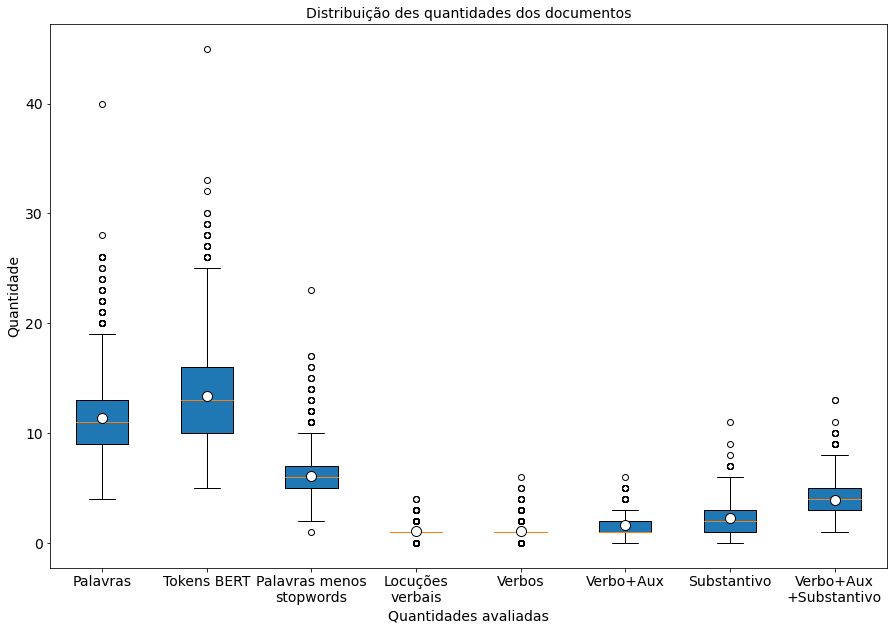

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdetokensbert"] for x in stats_documentos],
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Tokens BERT", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.2.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_documentos_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_pos])

# Exibe as estatísticas
df_stats_documentos_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1.42e+03,1419.0,1.42e+03,1.0
mean,0.77,1.10,1.12,1.38,2.26,0.50,0.10,1.74,1.05,0.65,0.33,0.15,0.26,4.23e-03,0.0,7.05e-04,2.0
std,0.82,0.78,0.44,0.84,1.37,0.54,0.33,1.25,1.24,0.80,0.57,0.40,0.51,6.49e-02,0.0,2.65e-02,NaN
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
25%,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
50%,1.00,1.00,1.00,1.00,2.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
75%,1.00,1.00,1.00,2.00,3.00,1.00,0.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
max,4.00,6.00,5.00,6.00,11.00,3.00,3.00,8.00,10.00,5.00,4.00,3.00,3.00,1.00e+00,0.0,1.00e+00,2.0


Organiza os dados para gerar o boxplot

In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_documentos_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

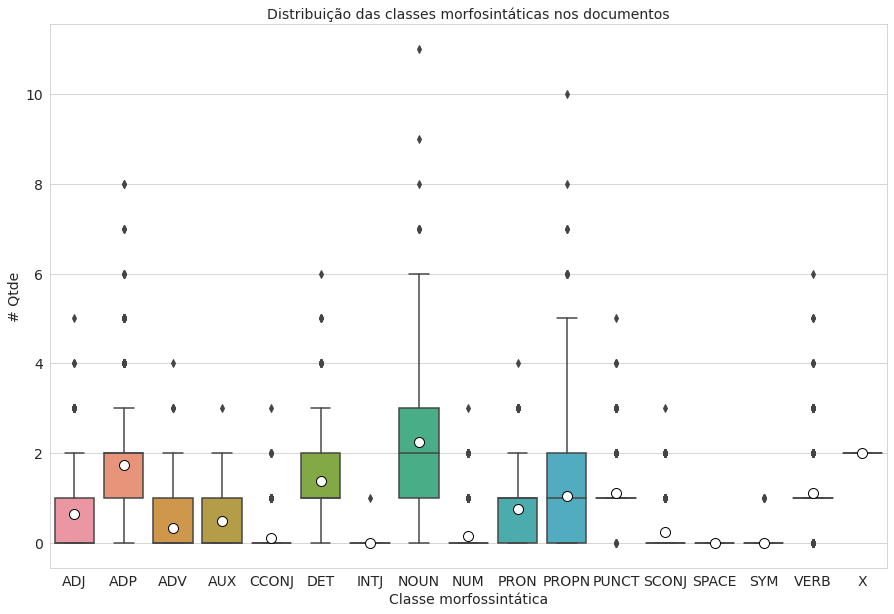

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_documentos_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_documentos_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

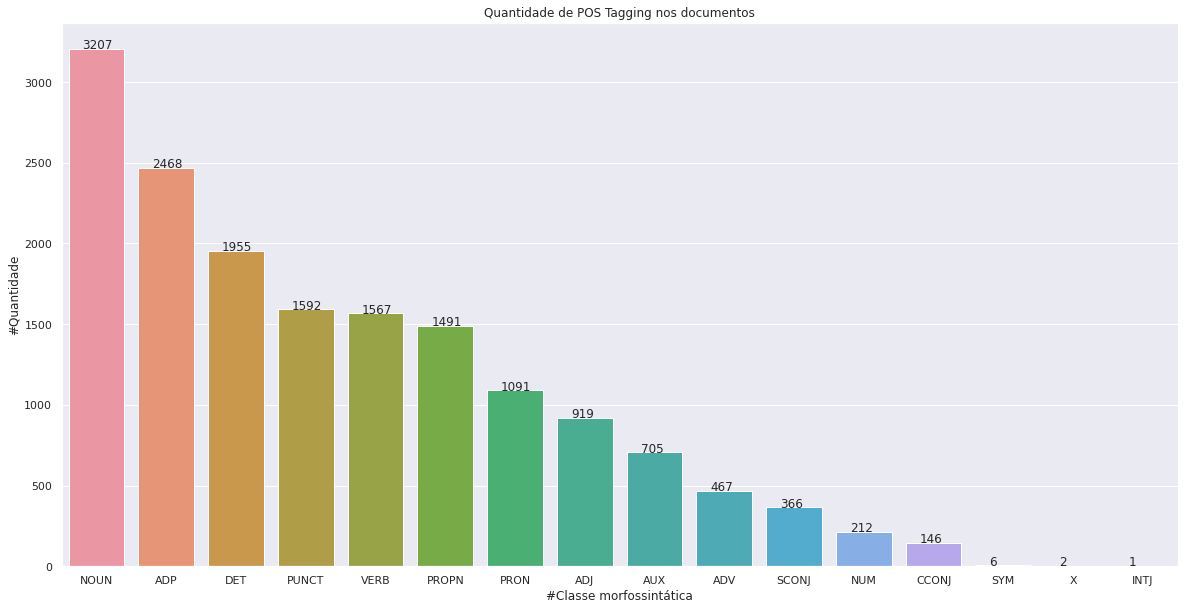

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_palavras_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_palavras_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.2.3.3 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [ ]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

? => 1410
de => 730
que => 560
o => 480
a => 438
do => 242
em => 234
da => 234
é => 217
Qual => 217
O => 200
os => 182
foi => 171
Que => 169
para => 137
e => 128
Quem => 124
, => 117
um => 116
Em => 110


#### 5.2.3.4 Lista palavras desconhecidas e ocorrências

Lista as 20 palavras desconhecidas pelo BERT com maiores ocorrência.

In [ ]:
lista_palavras_desconhecidas_ocorrencias = []

for palavra in sorted(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))):
  conta = 0  
  tokenizada = ""
  for x in sorted(lista_palavras_desconhecidas_geral, key = lambda x: x[0]):
    if x[0] == palavra:
      conta = conta + 1
      tokenizada = x[1]
  #print(palavra, "=>", tokenizada, "=>", conta)
  lista_palavras_desconhecidas_ocorrencias.append([palavra, tokenizada, conta])
  
for i, palavra in enumerate(sorted(lista_palavras_desconhecidas_ocorrencias, key = lambda x: x[2], reverse=True)):
  if i < 20:
     print(palavra[0], "=>", palavra[1], "=>", palavra[2])

Quais => ['Qu', '##ais'] => 57
Quantos => ['Quanto', '##s'] => 35
Quantas => ['Qu', '##antas'] => 32
quê => ['qu', '##ê'] => 27
Kanye => ['Kan', '##ye'] => 8
Feynman => ['Fe', '##yn', '##man'] => 5
Somália => ['Som', '##ália'] => 5
quantos => ['quanto', '##s'] => 5
zinco => ['z', '##inco'] => 5
Chopin => ['Cho', '##pin'] => 4
Dell => ['Del', '##l'] => 4
Netuno => ['Net', '##uno'] => 4
Oklahoma => ['Ok', '##lah', '##om', '##a'] => 4
Popper => ['Pop', '##per'] => 4
quantas => ['quant', '##as'] => 4
Alcorão => ['Alco', '##rão'] => 3
Antártica => ['Antár', '##tica'] => 3
BYU => ['B', '##Y', '##U'] => 3
BeiDou => ['Bei', '##Do', '##u'] => 3
Beyonce => ['Be', '##yon', '##ce'] => 3


### 5.2.4 Por sentença

#### 5.2.4.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,id,sentenca,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas
count,1419,1419.0,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00
unique,1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5a8d89b5df8bba001a0f9afb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,11.41,13.34,6.13,1.08,1.10,1.60,2.26,3.86,1.32
std,NaN,0.0,3.88,4.48,2.21,0.66,0.78,0.81,1.37,1.70,1.05
min,NaN,0.0,4.00,5.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,NaN,0.0,9.00,10.00,5.00,1.00,1.00,1.00,1.00,3.00,1.00
50%,NaN,0.0,11.00,13.00,6.00,1.00,1.00,1.00,2.00,4.00,1.00
75%,NaN,0.0,13.00,16.00,7.00,1.00,1.00,2.00,3.00,5.00,2.00


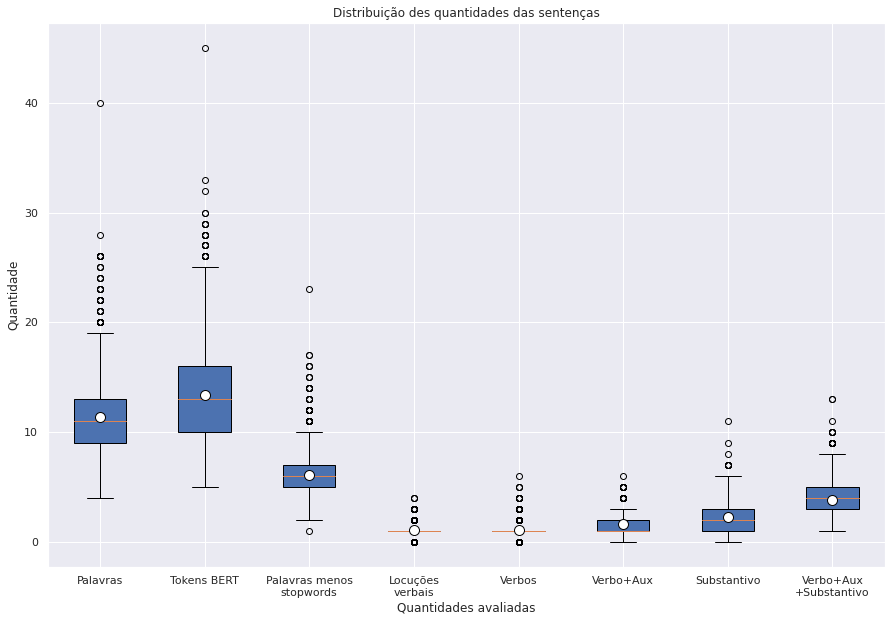

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdetokensbert"] for x in stats_sentencas],
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],
           [x["qtdelocverbo"] for x in stats_sentencas],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Tokens BERT", 
                     "Palavras menos\nstopwords", 
                     "Locuções\nverbais", 
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo"])

# Mostra o gráfico
plt.show()

#### 5.2.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_pos])

# Exibe as estatísticas
df_stats_sentencas_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1.42e+03,1419.0,1.42e+03,1.0
mean,0.77,1.10,1.12,1.38,2.26,0.50,0.10,1.74,1.05,0.65,0.33,0.15,0.26,4.23e-03,0.0,7.05e-04,2.0
std,0.82,0.78,0.44,0.84,1.37,0.54,0.33,1.25,1.24,0.80,0.57,0.40,0.51,6.49e-02,0.0,2.65e-02,NaN
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
25%,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
50%,1.00,1.00,1.00,1.00,2.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
75%,1.00,1.00,1.00,2.00,3.00,1.00,0.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00e+00,0.0,0.00e+00,2.0
max,4.00,6.00,5.00,6.00,11.00,3.00,3.00,8.00,10.00,5.00,4.00,3.00,3.00,1.00e+00,0.0,1.00e+00,2.0


In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

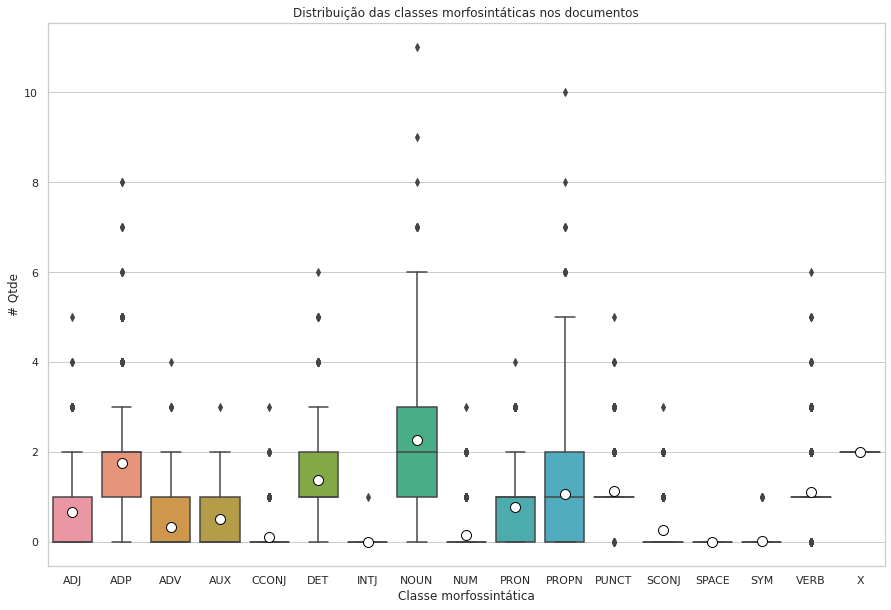

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

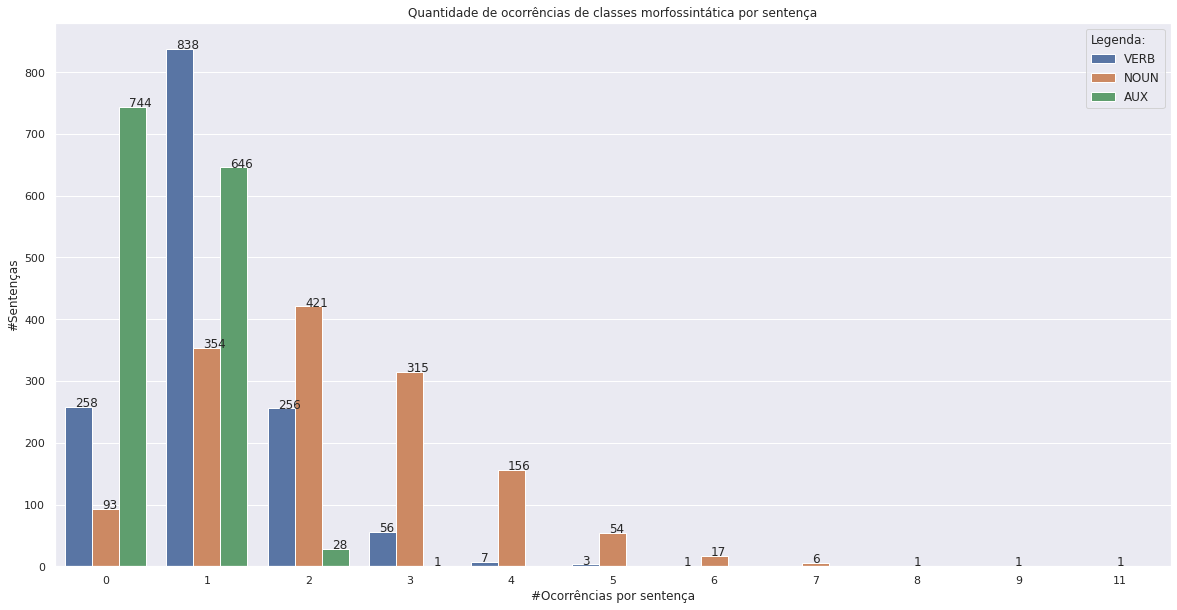

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_pos[df_stats_sentencas_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 20(#Sentenças) sentenças onde palavras da classe morfossintática verbo(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.2.4.3 Gráficos POS Tagging de sentenças do documento original

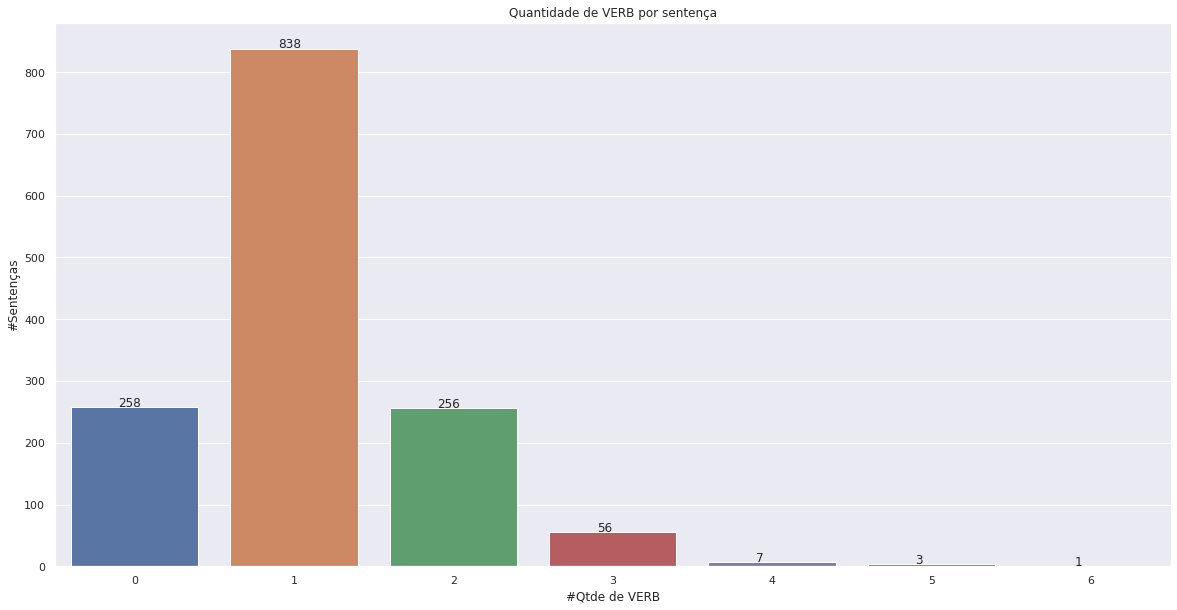

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

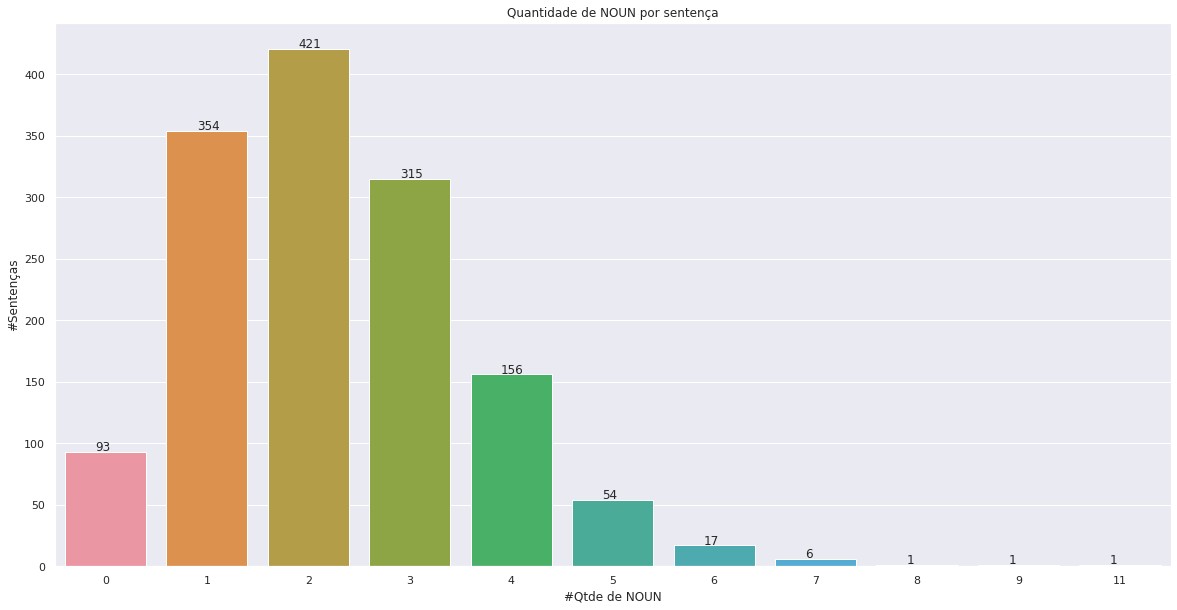

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

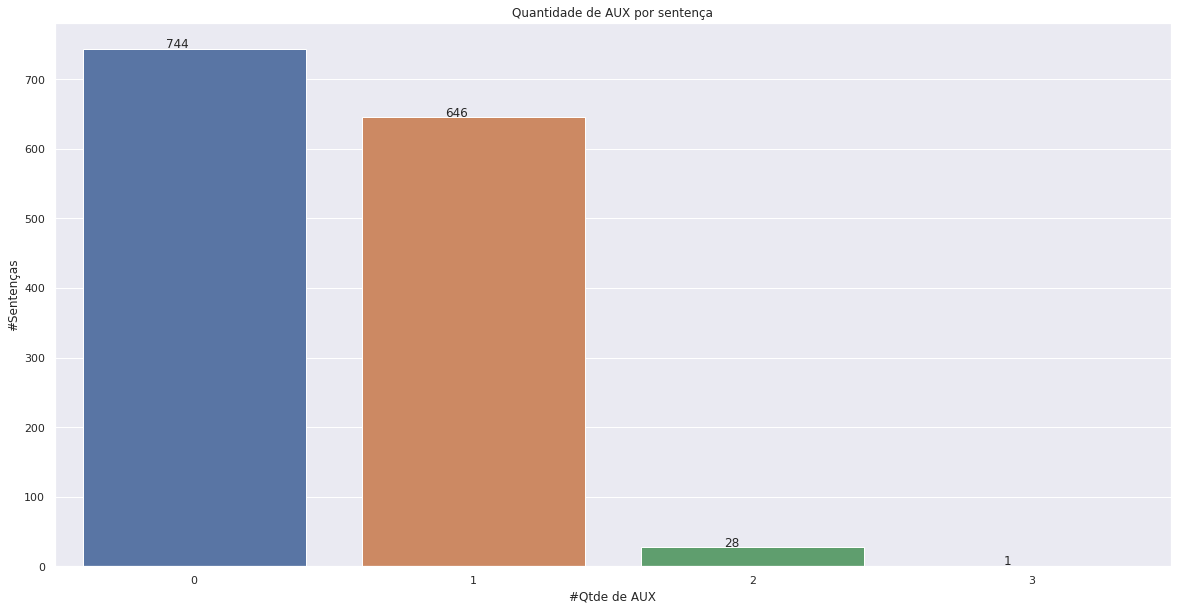

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

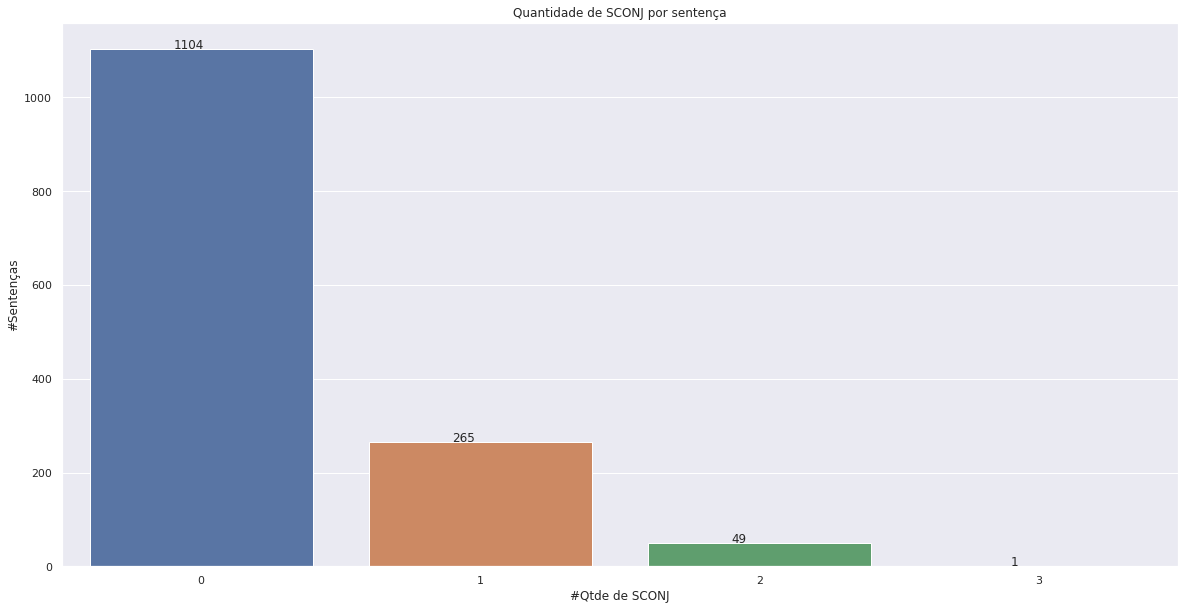

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

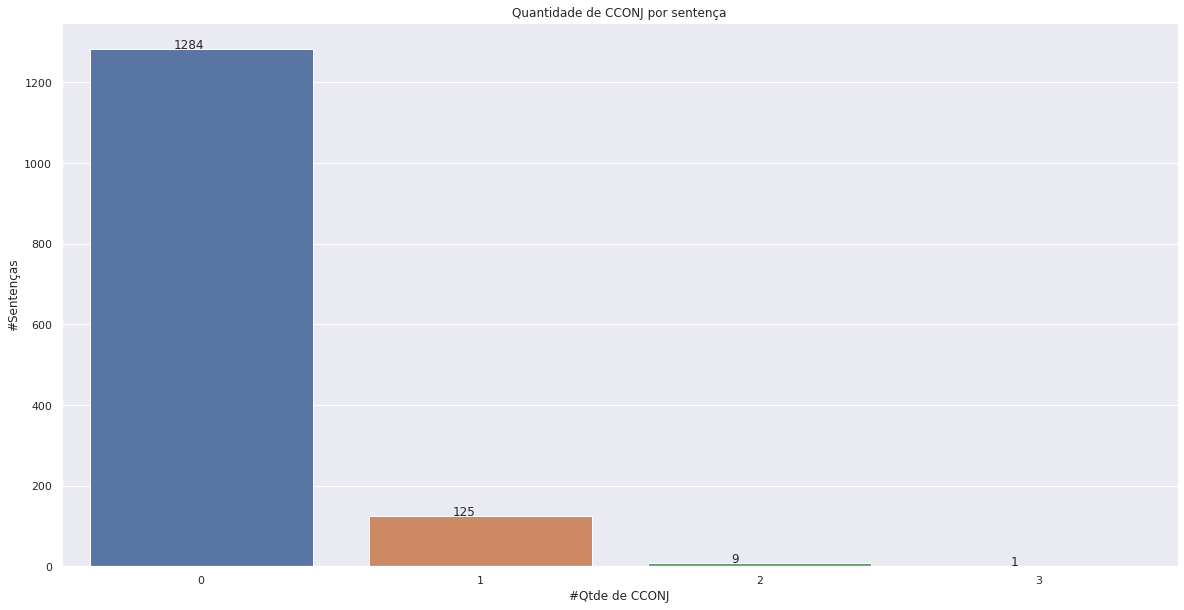

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

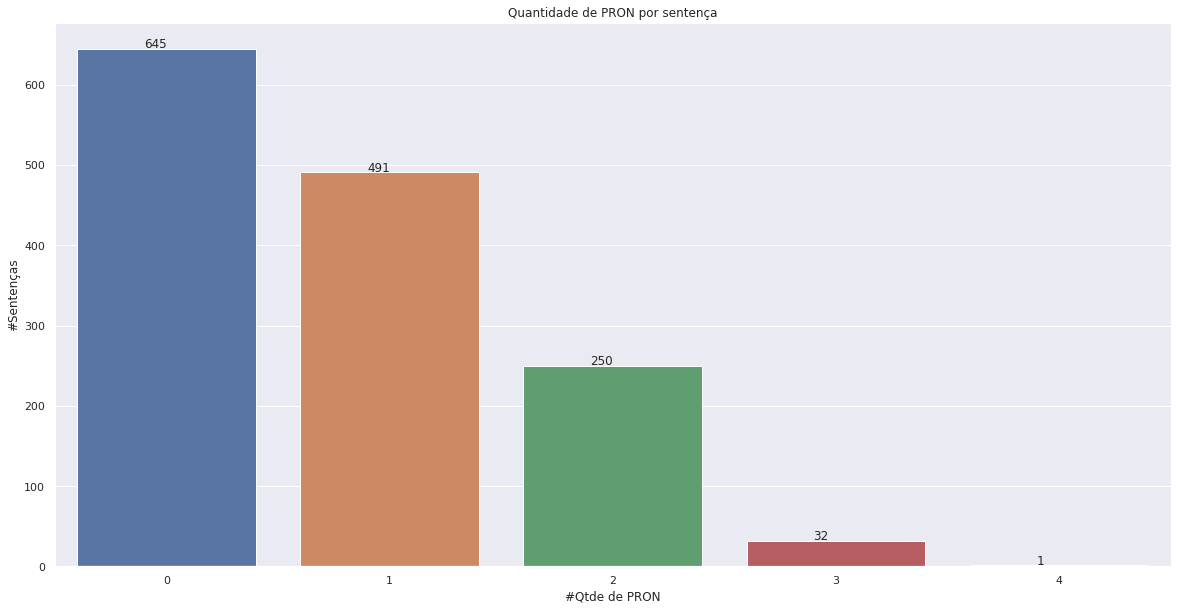

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

### 5.2.5 Por Documento

#### 5.2.5.1 Gráfico Quantidade de documentos originais por quantidade de sentenças

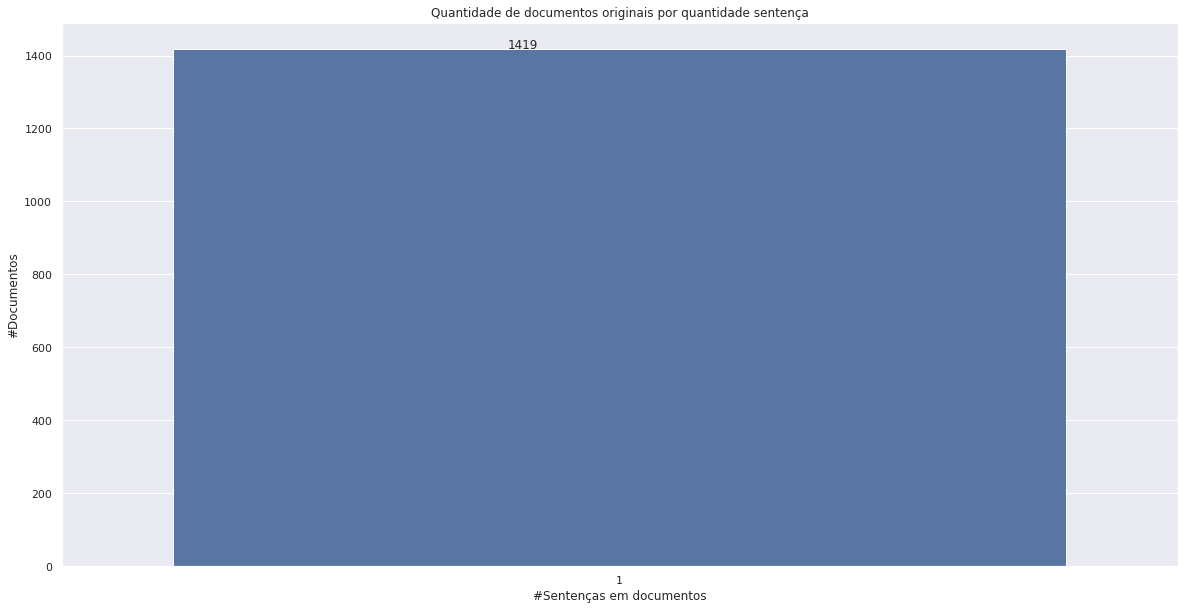

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.2 Gráfico Quantidade de documentos originais por quantidade de palavras

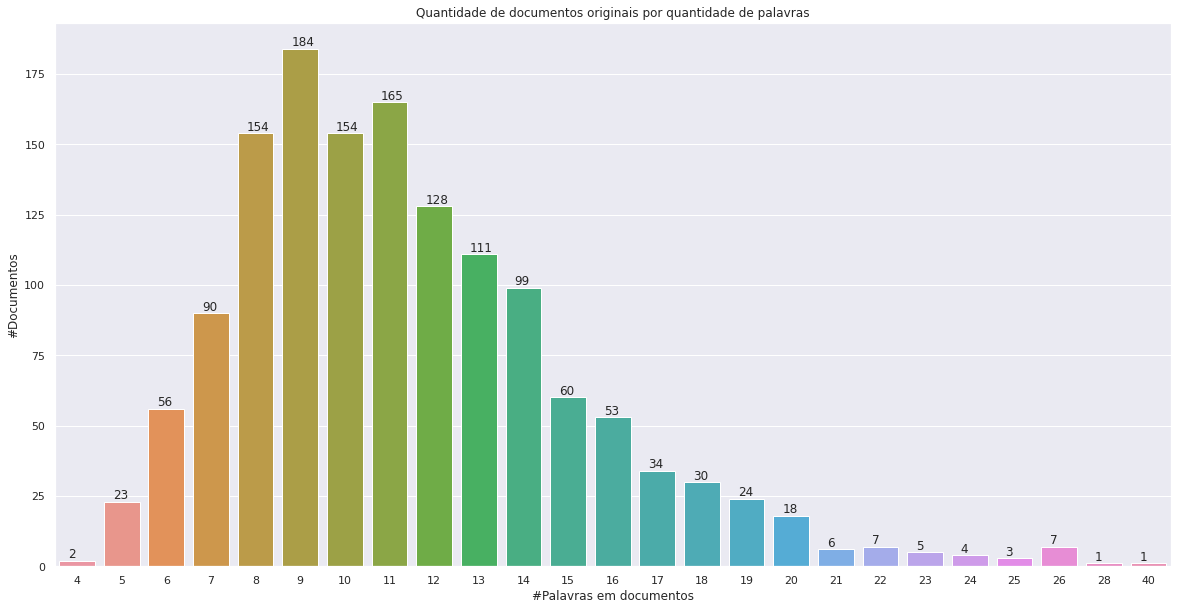

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.3 Gráfico Quantidade de documentos originais por quantidade de tokens

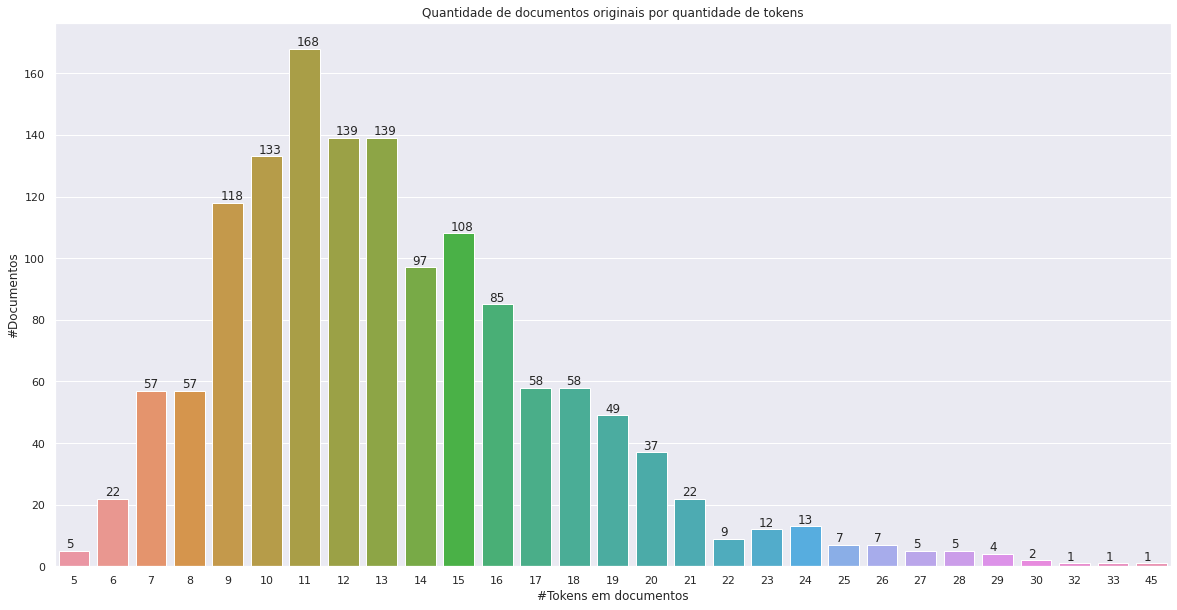

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.2, p.get_height()+1))

plt.title("Quantidade de documentos originais por quantidade de tokens")
plt.xlabel("#Tokens em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.4 Gráfico Quantidade de documentos originais por quantidade de palavras desconsiderando as stopword

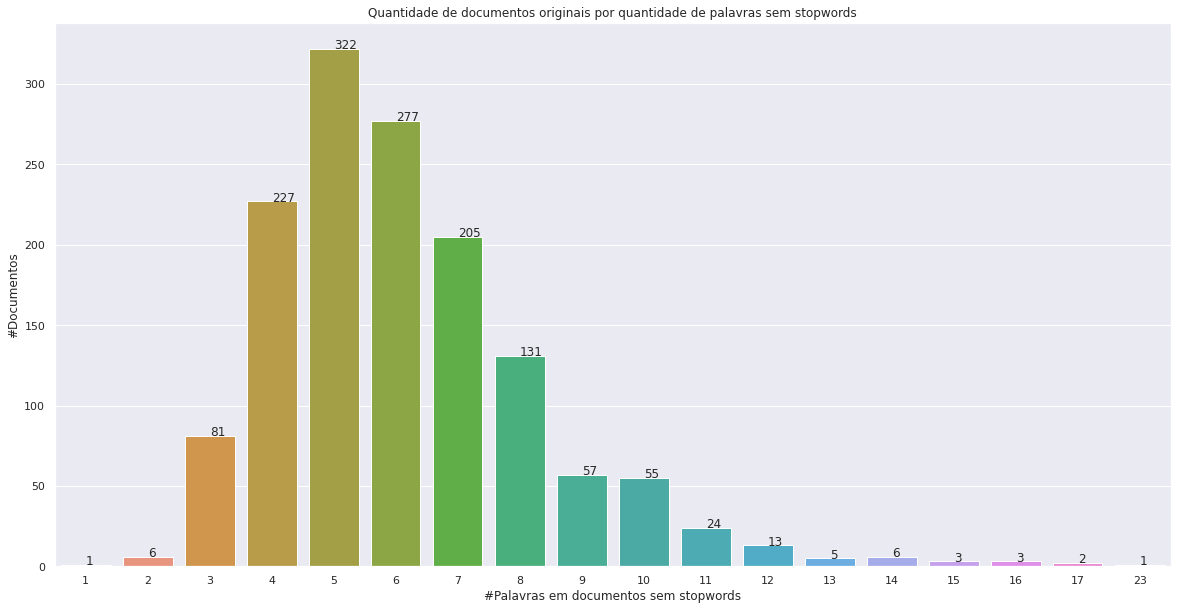

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.5 Gráfico Quantidade de documentos originais por quantidade de locuções verbais

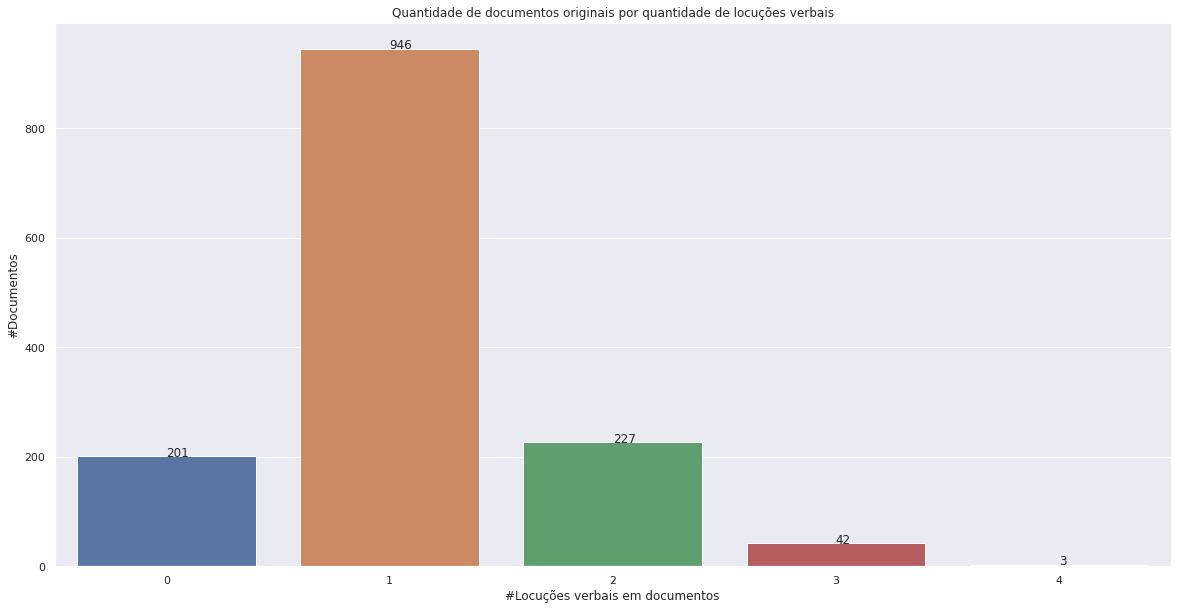

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.6 Gráfico Quantidade de documentos originais por quantidade de verbos

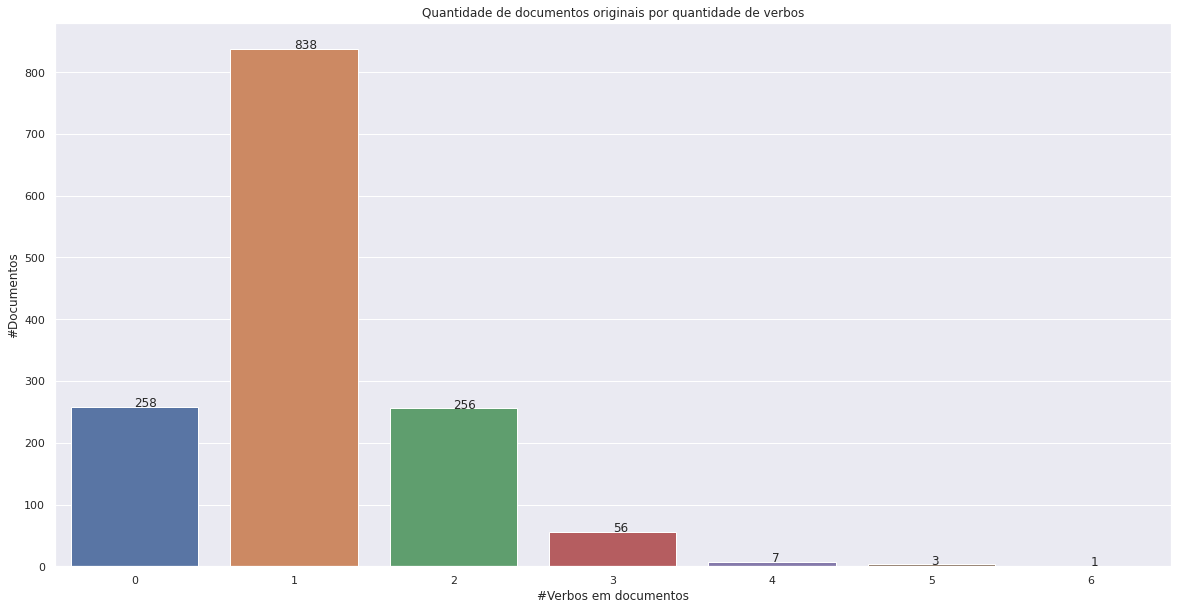

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.7 Gráfico Quantidade de documentos originais por quantidade de verbos e aux

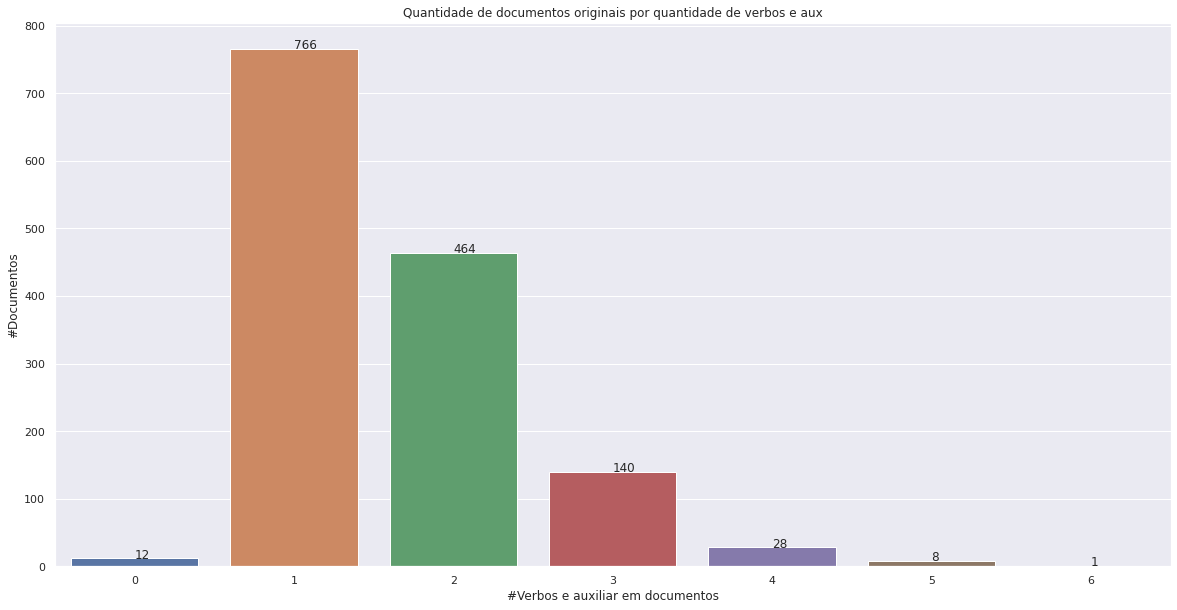

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.8 Gráfico Quantidade de documentos originais por quantidade de substantivos

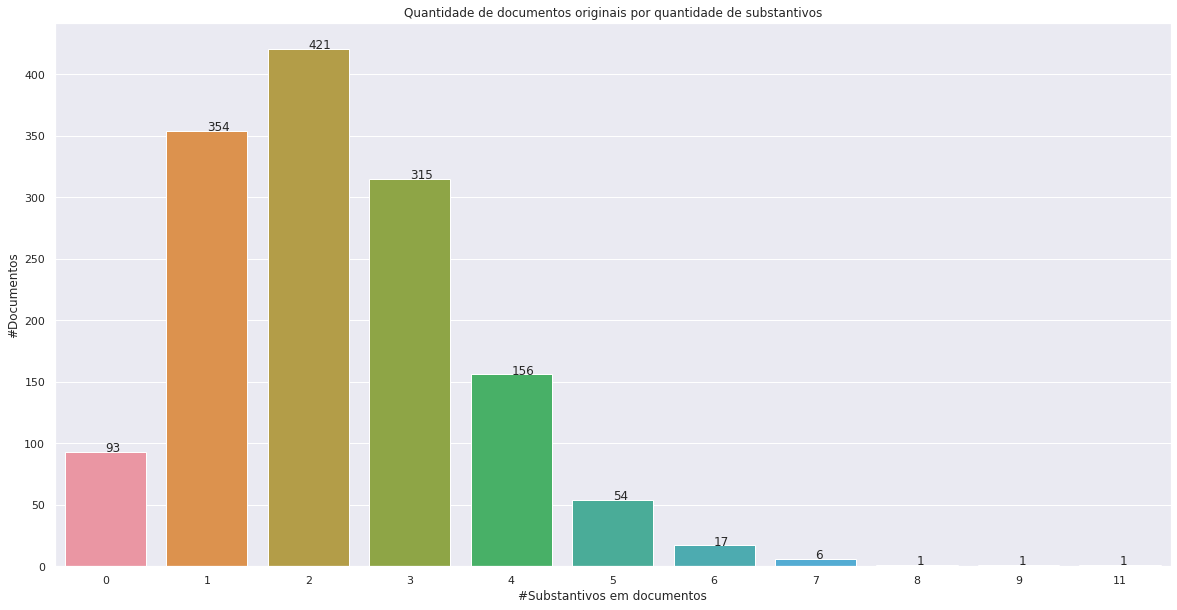

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.9 Gráfico Quantidade de documentos originais por quantidade de verbos(AUX) e substantivo

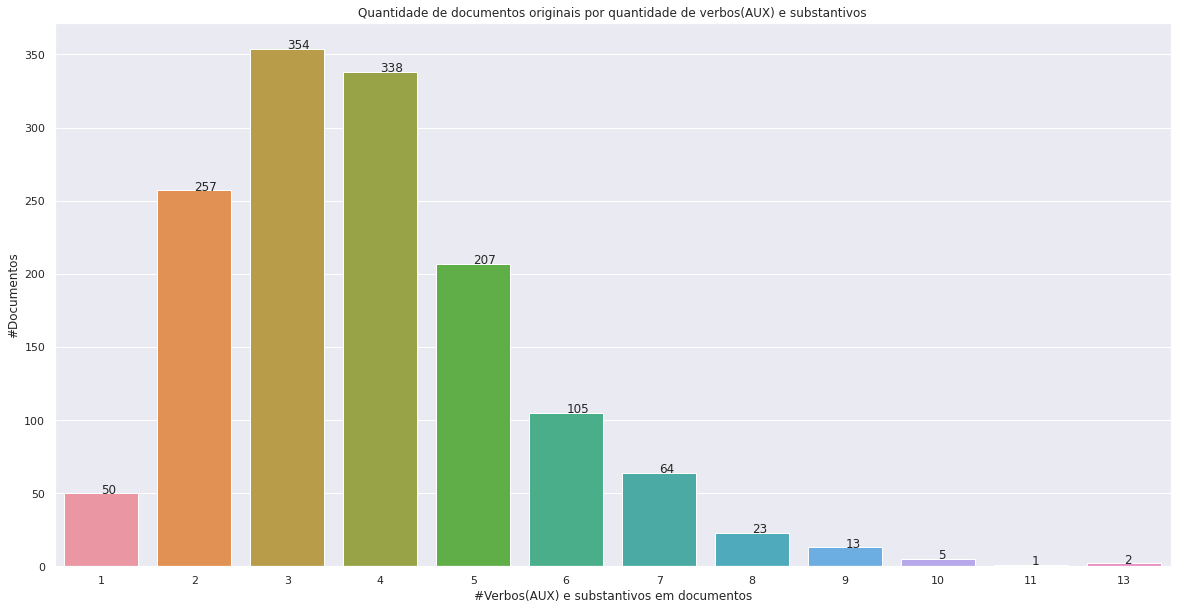

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.2.5.10 Gráfico da distribuição do comprimento dos documentos tokenizados

In [ ]:
# Recupera o comprimento dos documentos tokenizados
tamanhos_sentencas = [len(x) for x in documento_tokenizado]

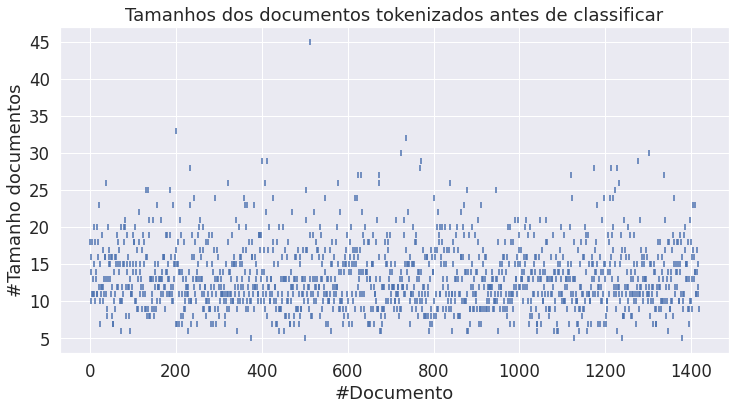

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Adiciona os valores as colunas
plt.scatter(range(0, len(tamanhos_sentencas)), tamanhos_sentencas, marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados antes de classificar")

plt.show()

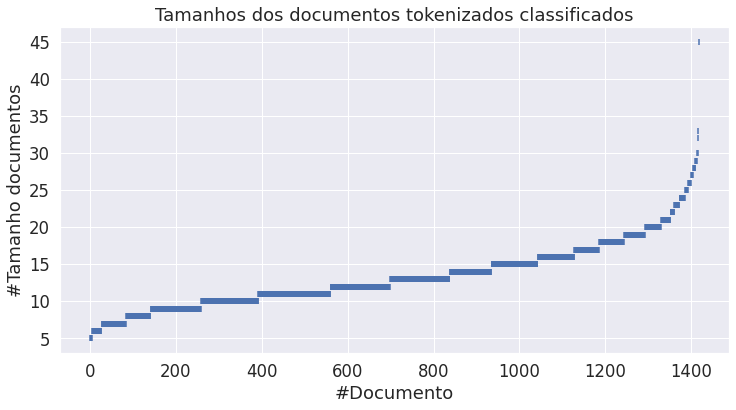

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(tamanhos_sentencas)), sorted(tamanhos_sentencas), marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados classificados")

plt.show()

### 5.2.6 Por sentença

#### 5.2.6.1 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras

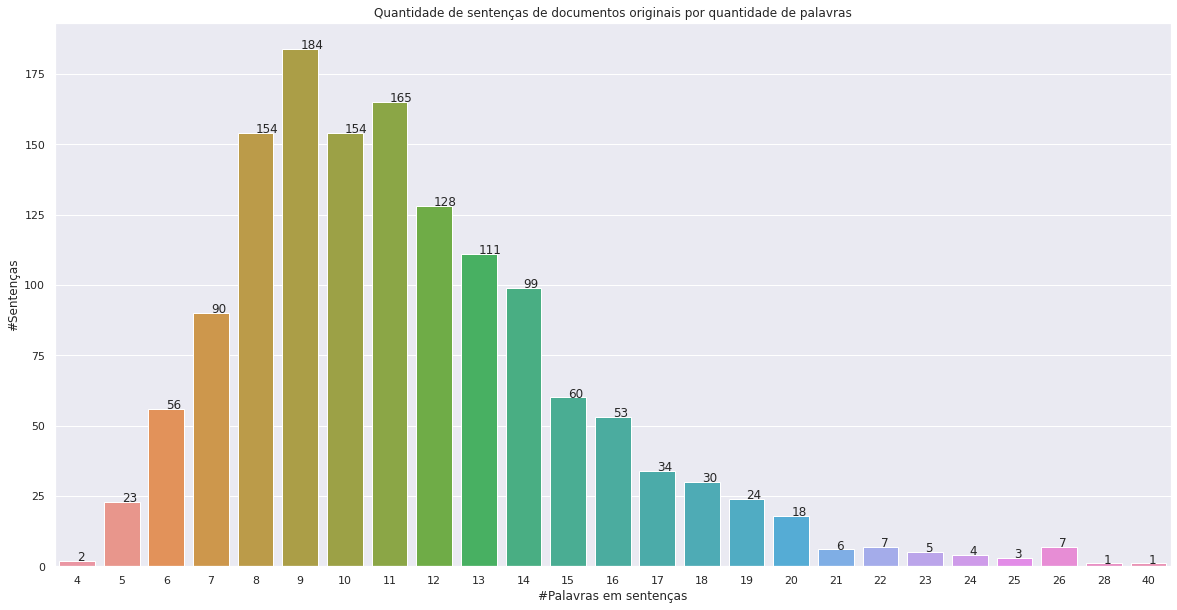

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.2 Gráfico Quantidade de sentenças de documentos originais por quantidade de tokens

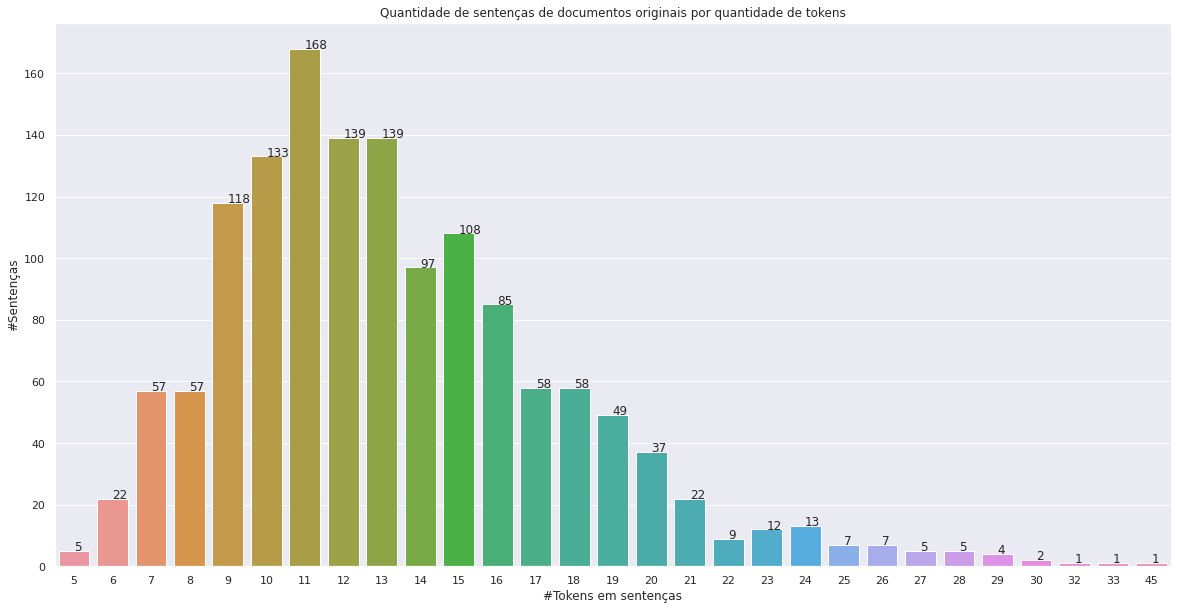

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de tokens")
plt.xlabel("#Tokens em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.3 Gráfico Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopwords

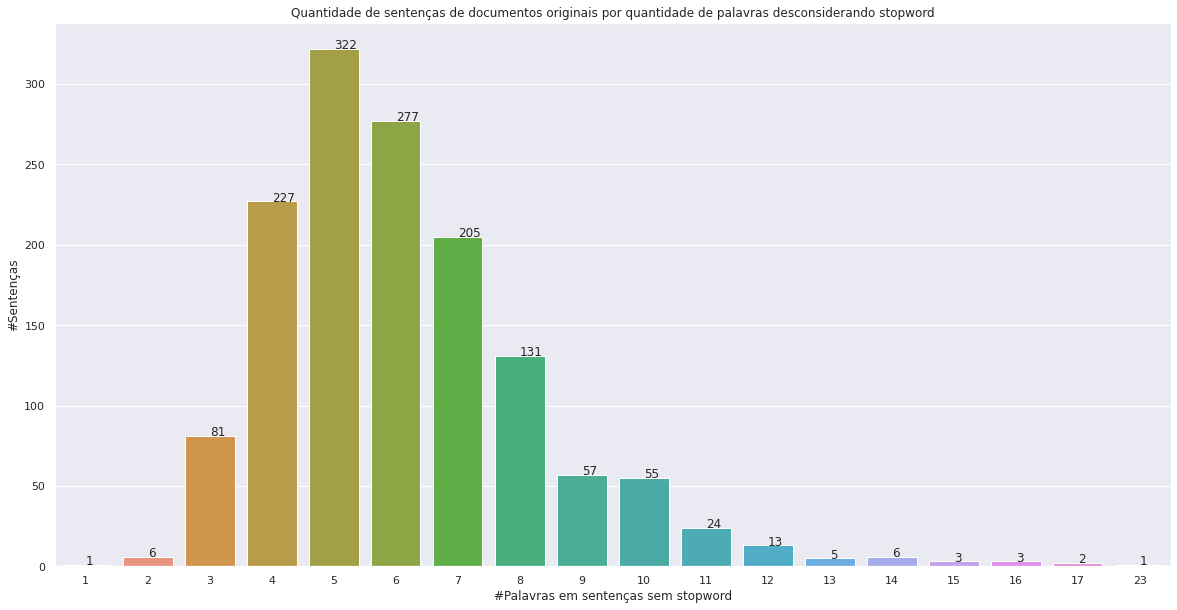

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.4 Gráfico Quantidade de sentenças de documentos originais por quantidade de locuções verbais

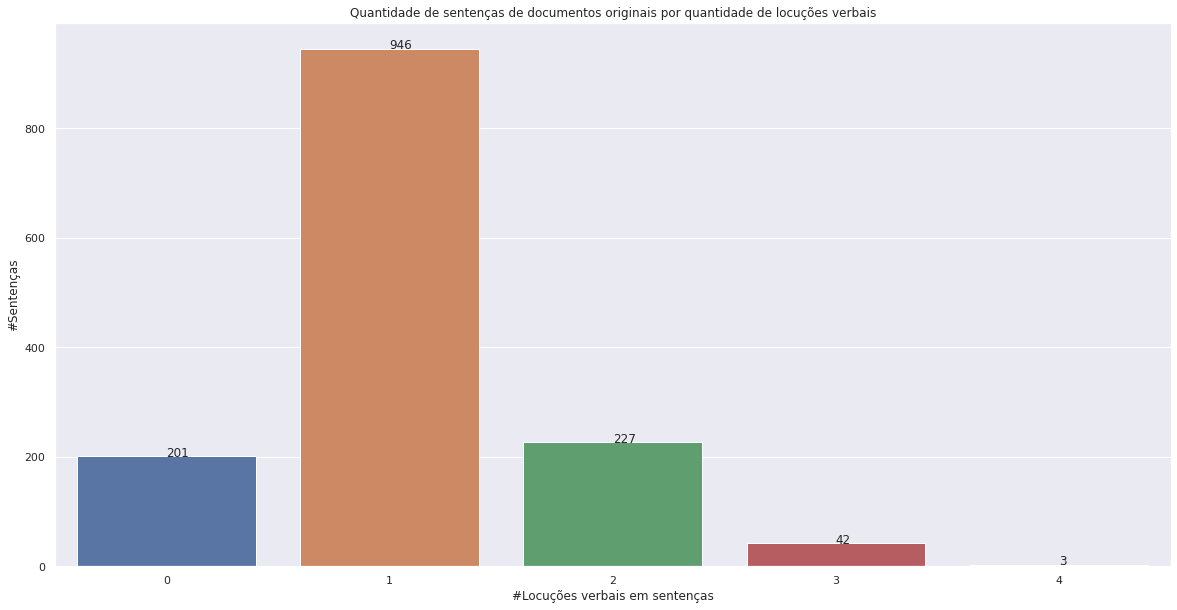

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.5 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos

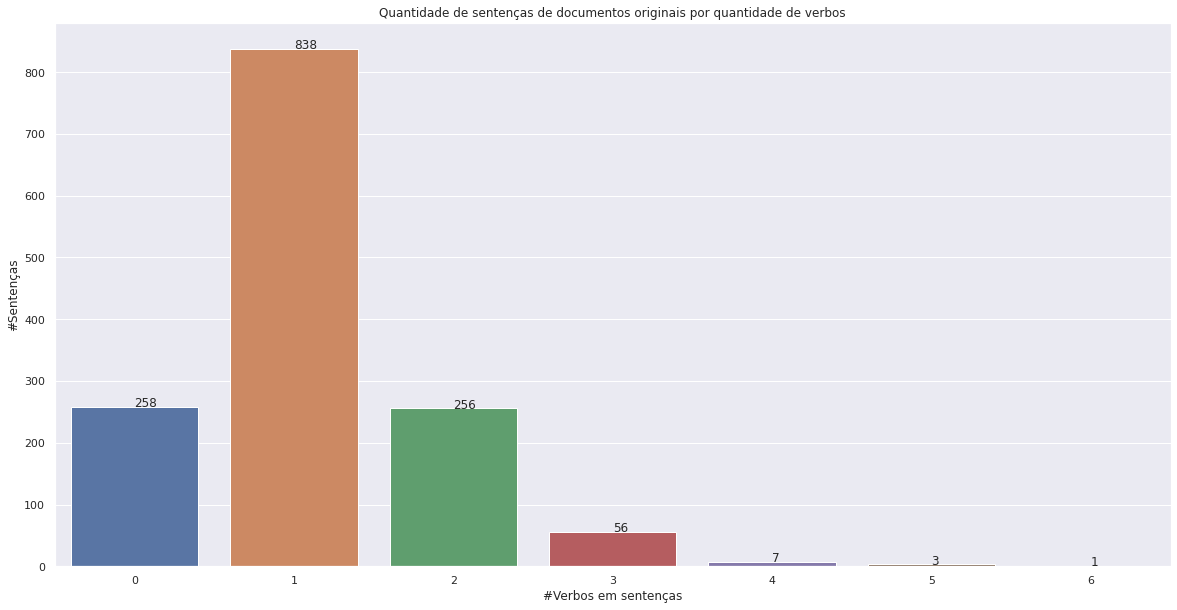

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.6 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos e aux

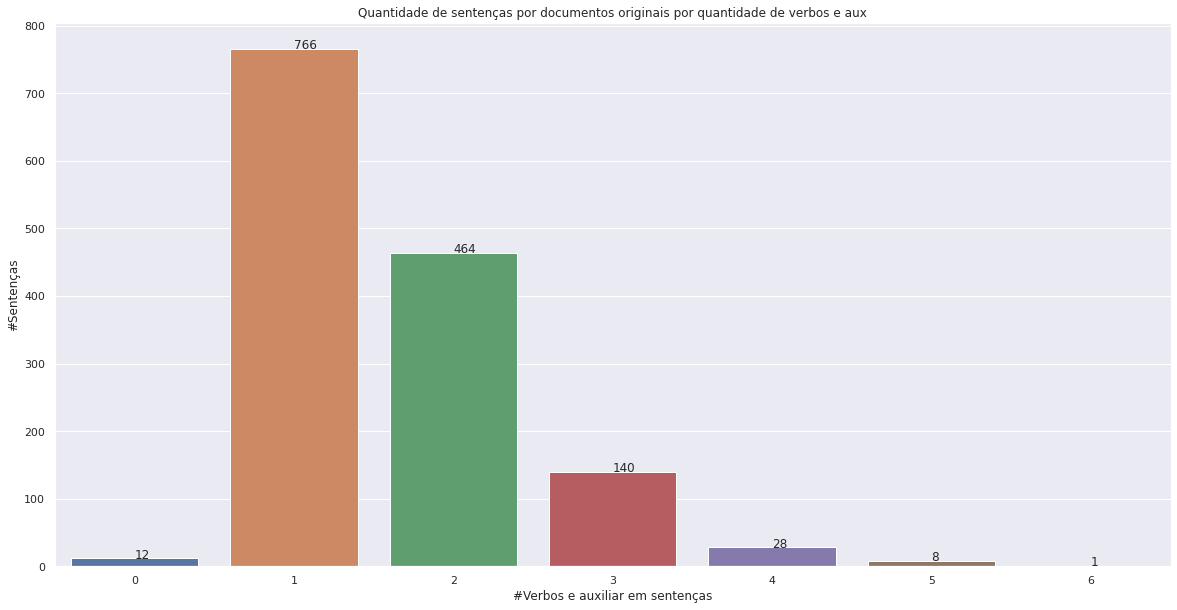

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos originais por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.7 Gráfico Quantidade de sentenças de documentos originais por quantidade de substantivos

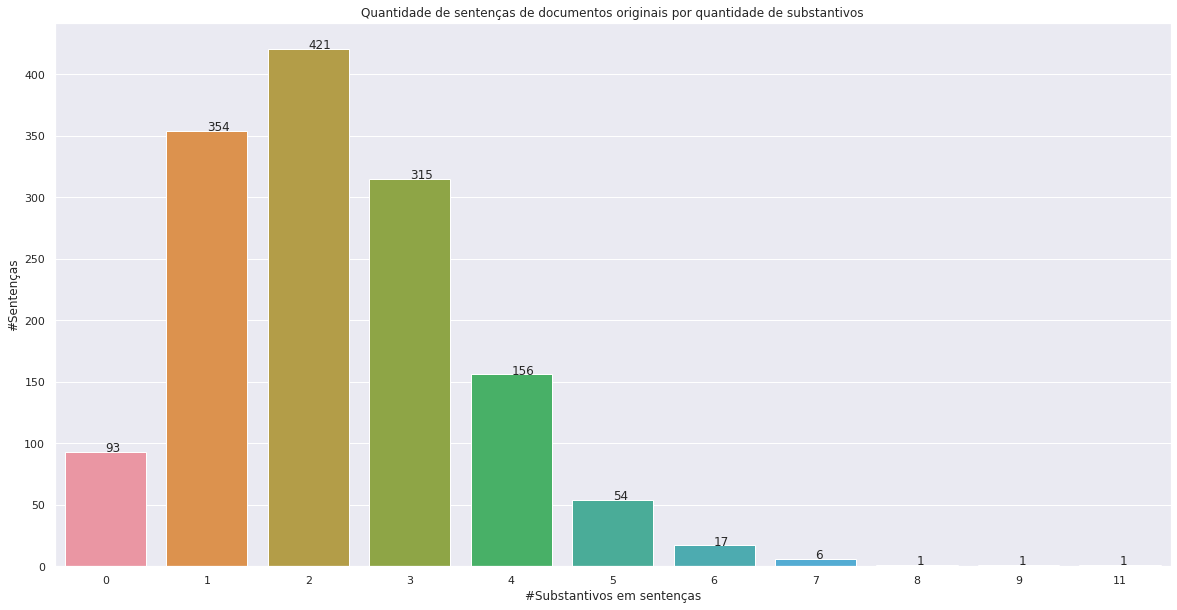

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.2.6.8 Gráfico Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivo

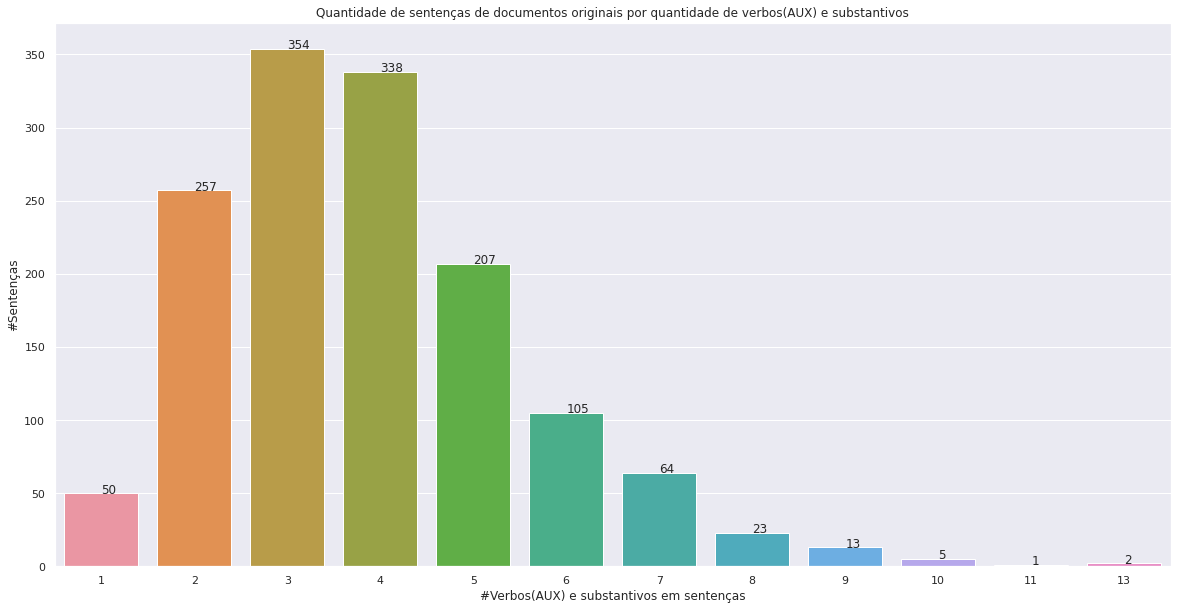

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos originais por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

## 5.3 Estatísticas Dados Perturbados

### 5.3.1 Processamento estatísticas



In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Lista das estatísticas
stats_documentos = []
stats_documentos_pos = []
stats_sentencas = []
stats_sentencas_pos = []
stats_pos_palavras_sentenca_documento =[]

print("Processando",len(lista_documentos_perturbados),"documentos perturbados")

total_sentencas_geral = 0
total_palavras_geral = 0
total_palavras_sem_stopwords_geral = 0
total_tokens_geral = 0
qtde_abaixo_512 = 0
total_2_ou_mais_locucoes_verbais = 0
sentencas_com_uma_palavra = 0

total_verbos_documento_geral = 0
total_verbos_aux_documento_geral = 0
total_substantivo_documento_geral = 0
total_verbos_aux_substantivo_documento_geral = 0

dicionario_palavras = {}
lista_palavras_desconhecidas_geral = []
documento_tokenizado = []

# Barra de progresso dos documentos
lista_documentos_perturbados_bar = tqdm_notebook(lista_documentos_perturbados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_perturbados))

# Percorre os documentos
for i, linha_documento in lista_documentos_perturbados_bar:  
 
    id_documento = linha_documento[0]
    #print("id_documento:",id_documento)

    # Carrega a lista das sentenças do documento de acordo com o tipo armazenado
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Localiza e carrega a lista das POSTagging das sentenças do documento de acordo com o tipo armazenado
    # Descarta a posição 0 com o id do documento e considera somente a posição 1 com as sentenças
    lista_pos_documento = lista_documentos_perturbados_pos.iloc[i][1]    
    #print("lista_pos_documento:",lista_pos_documento)
    #print("len(lista_pos_documento):",len(lista_pos_documento)) 
    
    # Calcula o total de sentenças do documento
    total_sentencas_geral = total_sentencas_geral + len(lista_sentenca_documento)

    total_palavras_documento = 0    
    total_palavras_sem_stopword_documento = 0
    total_tokens_BERT_documento = 0
    total_locucoes_verbais_documento = 0

    total_verbos_documento = 0
    total_verbos_aux_documento = 0
    total_substantivo_documento = 0
    total_verbos_aux_substantivo_documento = 0

    lista_palavras_desconhecidas_documento = []
    
    # Acumula os dicionários de POS das sentenças
    lista_pos_doc = []

    # Acumula a lista de  POS das sentenças
    stats_pos_palavras_sentenca = []
  
    # Guarda as sentenças tokenizadas pelo BERT do documento
    documento_tokenizado_sentenca = []

    for j, sentenca in enumerate(lista_sentenca_documento):

      #print("id_documento:",id_documento)
      #print("sentenca:",sentenca)
      sentenca_token = lista_pos_documento[j][0]
      #print("sentenca_token:",sentenca_token)
      #print("len(sentenca_token):",len(sentenca_token))
      sentenca_pos = lista_pos_documento[j][1]
      #print("sentenca_pos:",sentenca_pos)
      sentenca_verbos = lista_pos_documento[j][2]
      #print("sentenca_verbos:",sentenca_verbos)
    
      # Quantidade de palavras por Sentença
      qtdePalavra = len(sentenca_token)

      # Conta sentenças com uma palavra
      if qtdePalavra == 1:
        sentencas_com_uma_palavra = sentencas_com_uma_palavra + 1
       
      # Retorna uma lista com os verbos da sentença      
      qtde_locucoes_verbais_sentenca = len(sentenca_verbos)
      total_locucoes_verbais_documento = total_locucoes_verbais_documento + qtde_locucoes_verbais_sentenca

      if qtde_locucoes_verbais_sentenca >= 2:
          total_2_ou_mais_locucoes_verbais = total_2_ou_mais_locucoes_verbais + 1
      
      # Retorna os tokens da sentença sem as stopwords
      sentencaSemStopWords = getSentencaSemStopWord(sentenca_token, getStopwords(nlp))
      
      # Quantidade de tokens por Sentença sem as stopwords
      qtde_palavra_sem_stopword = len(sentencaSemStopWords)
            
      # Acumula a quantidade de palavras da Sentença
      total_palavras_documento = total_palavras_documento + qtdePalavra

      # Acumula a quantidade de palavras da Sentença sem stopwords
      total_palavras_sem_stopword_documento = total_palavras_sem_stopword_documento + qtde_palavra_sem_stopword

      # Divide a Sentença em tokens do BERT
      sentenca_tokenizada = tokenizer.tokenize(sentenca)

      # Guarda a sentença tokenizada do documento
      documento_tokenizado_sentenca = documento_tokenizado_sentenca + sentenca_tokenizada

      # Quantidade de tokens por Sentença
      qtde_token_BERT = len(sentenca_tokenizada)     
      
      lista_palavras_desconhecidas_sentenca = getPalavrasDesconhecidasBERT(sentenca_tokenizada)
      
      # Acumula a quantidade de tokens da Sentença
      total_tokens_BERT_documento = total_tokens_BERT_documento + qtde_token_BERT

      # Gera as postagging das palavras da sentença
      pos_palavras_sentenca = []

      qtde_verbo_sentenca = 0
      qtde_verbo_aux_sentenca = 0
      qtde_substantivo_sentenca = 0
      qtde_verbo_aux_substantivo_sentenca = 0

      # Percorre as palavras da sentença
      for k, palavra in enumerate(sentenca_token):
        # Gera lista das POS Tagging   
        pos_palavras_sentenca.append([linha_documento[0], j, palavra, sentenca_pos[k]])
        
        # Estatísticas das palavras da sentença
        valor = dicionario_palavras.get(palavra)
        if valor != None:
            dicionario_palavras[palavra] = valor + 1
        else:
            dicionario_palavras[palavra] = 1

        if sentenca_pos[k] in ["VERB"]:
            qtde_verbo_sentenca = qtde_verbo_sentenca  + 1
        if sentenca_pos[k] in ["VERB","AUX"]:
            qtde_verbo_aux_sentenca = qtde_verbo_aux_sentenca  + 1
        if sentenca_pos[k] in ["NOUN"]:
            qtde_substantivo_sentenca = qtde_substantivo_sentenca + 1
        if sentenca_pos[k] in ["VERB","NOUN","AUX"]:                    
            qtde_verbo_aux_substantivo_sentenca = qtde_verbo_aux_substantivo_sentenca  + 1

      # Registra as estatística da quantidade de palavras da Sentença
      stats_sentencas.append(
         {  
            "id": id_documento,  
            "sentenca": j,  
            "qtdepalavras" : qtdePalavra,                        
            "qtdetokensbert" : qtde_token_BERT,
            "qtdepalavrassemstopword" : qtde_palavra_sem_stopword,
            "qtdelocverbo" : qtde_locucoes_verbais_sentenca ,
            "qtdeverbo" : qtde_verbo_sentenca ,
            "qtdeverboaux" : qtde_verbo_aux_sentenca,
            "qtdesubstantivo" : qtde_substantivo_sentenca,
            "qtdeverboauxsubstantivo" : qtde_verbo_aux_substantivo_sentenca,
            "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_sentenca),
         }
      )
      
      total_verbos_documento = total_verbos_documento + qtde_verbo_sentenca
      total_verbos_aux_documento = total_verbos_aux_documento + qtde_verbo_aux_sentenca
      total_substantivo_documento = total_substantivo_documento + qtde_substantivo_sentenca
      total_verbos_aux_substantivo_documento = total_verbos_aux_substantivo_documento + qtde_verbo_aux_substantivo_sentenca

      lista_palavras_desconhecidas_documento = lista_palavras_desconhecidas_documento + lista_palavras_desconhecidas_sentenca
      
      # Guarda as pos da sentença 
      stats_pos_palavras_sentenca = stats_pos_palavras_sentenca + pos_palavras_sentenca

      # Gera as estatísticas de POS Tagging da sentença
      contaPosSentenca = getDicTodasPOSQtde(sentenca_pos)

      # Registra as estatísticas de POS Tagging das sentenças
      stats_sentencas_pos.append([linha_documento[0], j, contaPosSentenca])

      # Acumula o dicionário de pos da sentença
      lista_pos_doc.append(contaPosSentenca)

    # Guarda as sentenças do documento tokenizada
    documento_tokenizado.append(documento_tokenizado_sentenca)

    # Acumula a postagging das sentenças do documento
    stats_pos_palavras_sentenca_documento = stats_pos_palavras_sentenca_documento + stats_pos_palavras_sentenca  

    # Guarda o total de palavras do conjunto de dados
    total_palavras_geral = total_palavras_geral + total_palavras_documento

    # Guarda o total de palavras do conjunto de dados
    total_palavras_sem_stopwords_geral = total_palavras_sem_stopwords_geral + total_palavras_sem_stopword_documento

    # Guarda o total de tokens do conjunto de dados
    total_tokens_geral = total_tokens_geral + total_tokens_BERT_documento

    # Guarda a lista de palavras desconhecidas
    lista_palavras_desconhecidas_geral = lista_palavras_desconhecidas_geral + lista_palavras_desconhecidas_documento

    if total_tokens_BERT_documento < 512 :
        qtde_abaixo_512 = qtde_abaixo_512 + 1

    if total_verbos_documento != 0:
      total_verbos_documento_geral = total_verbos_documento_geral + 1
    if total_verbos_aux_documento != 0:  
      total_verbos_aux_documento_geral = total_verbos_aux_documento_geral + 1
    if total_substantivo_documento != 0:
      total_substantivo_documento_geral = total_substantivo_documento_geral + 1
    if total_verbos_aux_substantivo_documento != 0:
      total_verbos_aux_substantivo_documento_geral = total_verbos_aux_substantivo_documento_geral + 1

    # Registra as estatística da divisão
    stats_documentos.append(
      {  
        "id": id_documento, 
        "qtdesentencas": len(lista_sentenca_documento),
        "qtdepalavras" : total_palavras_documento,                
        "qtdetokensbert" : total_tokens_BERT_documento,
        "qtdepalavrassemstopword" : total_palavras_sem_stopword_documento,
        "qtdelocverbo" : total_locucoes_verbais_documento,
        "qtdeverbo" : total_verbos_documento,
        "qtdeverboaux" : total_verbos_aux_documento,
        "qtdesubstantivo" : total_substantivo_documento,
        "qtdeverbosauxsubstantivo" : total_verbos_aux_substantivo_documento,
        "qtdepalavrasdesconhecidas" : len(lista_palavras_desconhecidas_documento),
      }
    )

    # Registra as estatísticas de POS Tagging dos documentos    
    stats_documentos_pos.append([linha_documento[0], lista_pos_doc])    

print("Total de Sentenças                             :", total_sentencas_geral)
print("Total de Sentenças com uma palavra             :", sentencas_com_uma_palavra)
print("Total de palavras                              :", total_palavras_geral)
print("Total de palavras distintas                    :", len(dicionario_palavras))
print("Total de palavras sem stopwords                :", total_palavras_sem_stopwords_geral)
print("Total de tokens BERT                           :", total_tokens_geral)
print("Total de documentos abaixo 512                 :", qtde_abaixo_512)  
print("Total de palavras desconhecidas repetidas      :", len(lista_palavras_desconhecidas_geral))  
print("Total de palavras desconhecidas sem repetições :", len(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral])))) 
print("Total de sentenças com 2 ou mais loc verbos    :", total_2_ou_mais_locucoes_verbais, "sendo {:.2%} do total de sentenças".format(total_2_ou_mais_locucoes_verbais/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB)            :", total_verbos_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_documento_geral/total_sentencas_geral))
print("Total de sentenças com Verbos(VERB e AUX)      :", total_verbos_aux_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_documento_geral/total_sentencas_geral))
print("Total de sentenças com substantivos(NOUN)      :", total_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_substantivo_documento_geral/total_sentencas_geral))
print("Total de sentenças com VERB, AUX e NOUN        :", total_verbos_aux_substantivo_documento_geral, "sendo {:.2%} do total de sentenças".format(total_verbos_aux_substantivo_documento_geral/total_sentencas_geral))

Processando 1419 documentos perturbados


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

Total de Sentenças                             : 1419
Total de Sentenças com uma palavra             : 0
Total de palavras                              : 16195
Total de palavras distintas                    : 4360
Total de palavras sem stopwords                : 8459
Total de tokens BERT                           : 18592
Total de documentos abaixo 512                 : 1419
Total de palavras desconhecidas repetidas      : 1598
Total de palavras desconhecidas sem repetições : 1288
Total de sentenças com 2 ou mais loc verbos    : 235 sendo 16.56% do total de sentenças
Total de sentenças com Verbos(VERB)            : 1025 sendo 72.23% do total de sentenças
Total de sentenças com Verbos(VERB e AUX)      : 1390 sendo 97.96% do total de sentenças
Total de sentenças com substantivos(NOUN)      : 1318 sendo 92.88% do total de sentenças
Total de sentenças com VERB, AUX e NOUN        : 1418 sendo 99.93% do total de sentenças


Converte a lista das pos tagging das palavras em um dataframe

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Converte em um dataFrame
dfstats_palavras_pos = pd.DataFrame(stats_pos_palavras_sentenca_documento, columns=("id", "sentenca", "palavra", "pos")) 

In [ ]:
dfstats_palavras_pos.sample(5)

,id,sentenca,palavra,pos
4398,5726d7ebf1498d1400e8ecd4_pert_0,0,imita,VERB
4343,56cf1a05aab44d1400b88d7f_pert_0,0,têm,VERB
10913,570b2526ec8fbc190045b869_pert_0,0,de,ADP
2980,572772165951b619008f8a15_pert_0,0,de,ADP
7448,56fa43e9f34c681400b0c045_pert_0,0,tipo,NOUN


### 5.3.2 Conjunto de dados



In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
lista = dfstats_palavras_pos.groupby(by=["pos"])['palavra']

# Mostra as estatísticas
lista.describe(include="all").transpose()

pos,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
count,961,2481,480,792,156,1966,1,3191,215,1107,1508,1597,369,6,1361,4
unique,632,65,108,30,3,63,1,1686,122,40,1025,8,23,2,721,4
top,primeiro,de,não,é,e,o,Construir,nome,dois,que,EUA,?,que,%,tem,mos
freq,18,703,68,267,135,447,1,52,15,378,25,1410,113,5,37,1


### 5.3.3 Por documento

#### 5.3.3.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_documentos)

df_stats.describe(include="all")

,id,qtdesentencas,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverbosauxsubstantivo,qtdepalavrasdesconhecidas
count,1419,1419.0,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00
unique,1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5a8d89b5df8bba001a0f9afb_pert_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.0,11.41,13.10,5.96,0.97,0.96,1.52,2.25,3.77,1.13
std,NaN,0.0,3.88,4.44,2.26,0.69,0.80,0.79,1.37,1.69,0.96
min,NaN,1.0,4.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,1.0,9.00,10.00,4.00,1.00,0.00,1.00,1.00,3.00,0.00
50%,NaN,1.0,11.00,12.00,6.00,1.00,1.00,1.00,2.00,4.00,1.00
75%,NaN,1.0,13.00,16.00,7.00,1.00,1.00,2.00,3.00,5.00,2.00


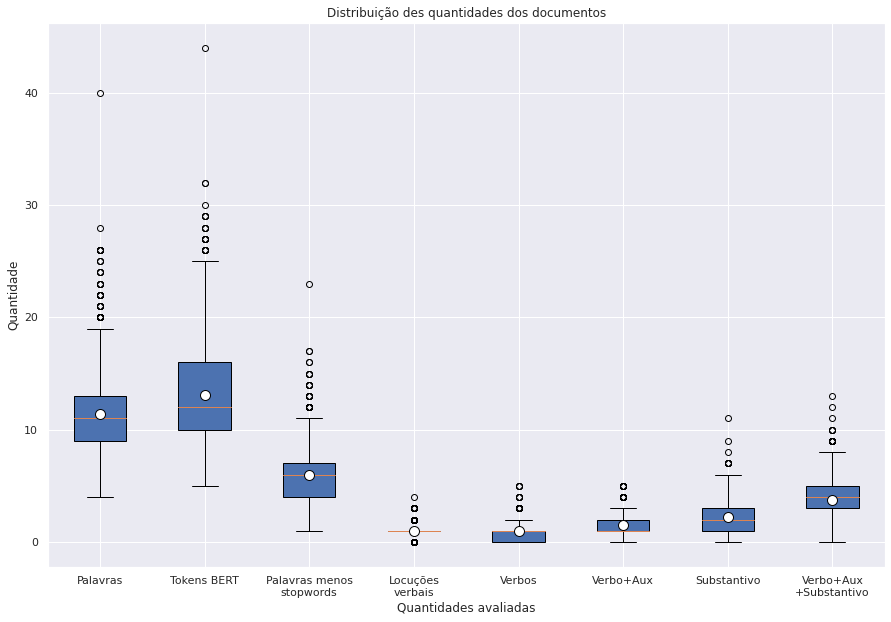

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades dos documentos")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_documentos], 
           [x["qtdetokensbert"] for x in stats_documentos],
           [x["qtdepalavrassemstopword"] for x in stats_documentos],
           [x["qtdelocverbo"] for x in stats_documentos],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
bplot1 = ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
rotulos = ["Palavras", 
           "Tokens BERT", 
           "Palavras menos\nstopwords", 
           "Locuções\nverbais", 
           "Verbos",
           "Verbo+Aux", 
           "Substantivo", 
           "Verbo+Aux\n+Substantivo"]
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, rotulos)

# Mostra o gráfico
plt.show()

#### 5.3.3.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_documentos_pos = pd.DataFrame([getSomaDic(x[1]) for x in stats_documentos_pos])

# Exibe as estatísticas
df_stats_documentos_pos.describe(include="all")

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1.42e+03,1419.0,1.42e+03,3.00
mean,0.78,0.96,1.13,1.39,2.25,0.56,0.11,1.75,1.06,0.68,0.34,0.15,0.26,4.23e-03,0.0,7.05e-04,1.33
std,0.83,0.80,0.45,0.84,1.37,0.54,0.34,1.25,1.24,0.82,0.58,0.41,0.52,6.49e-02,0.0,2.65e-02,0.58
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
25%,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
50%,1.00,1.00,1.00,1.00,2.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
75%,1.00,1.00,1.00,2.00,3.00,1.00,0.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.50
max,4.00,5.00,5.00,6.00,11.00,3.00,3.00,8.00,10.00,5.00,4.00,3.00,3.00,1.00e+00,0.0,1.00e+00,2.00


Organiza os dados para gerar o boxplot

In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_documentos_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic(x[1])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_documentos_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

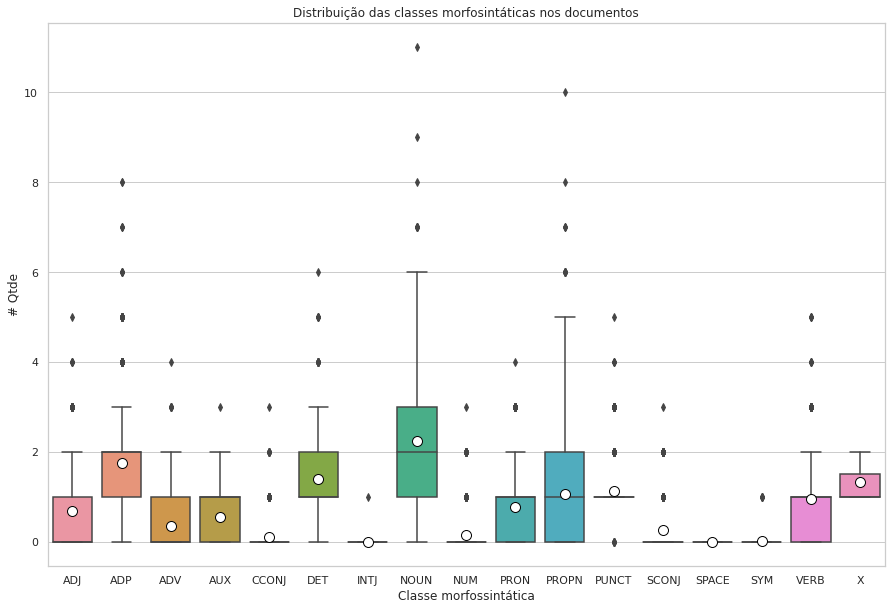

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_documentos_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_documentos_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de POS Tagging nos documentos

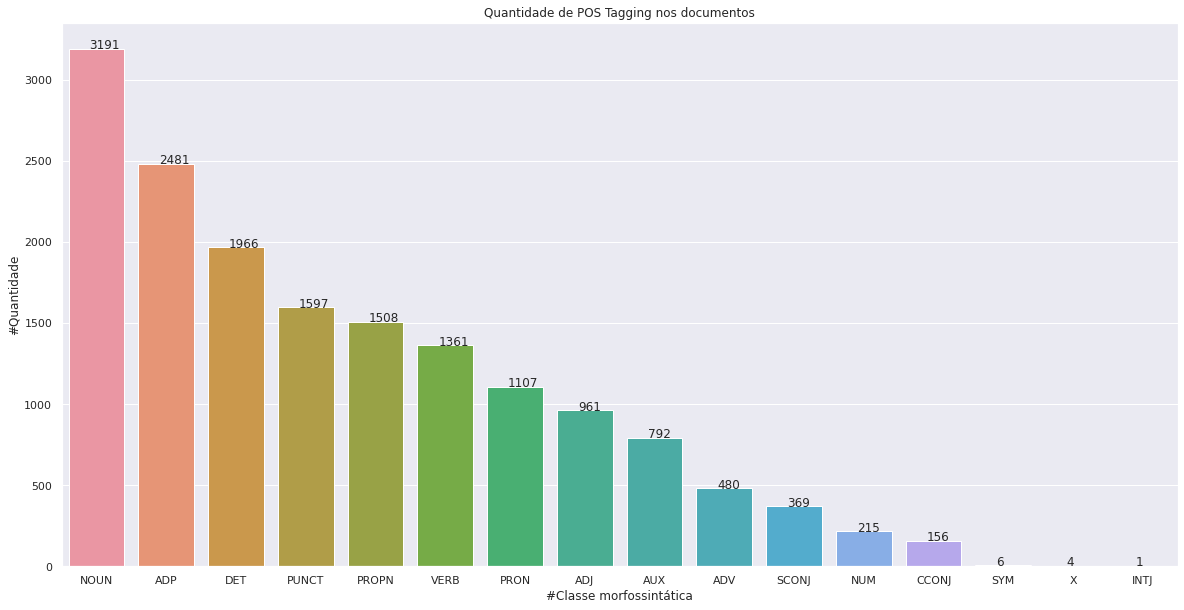

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Lista em ordem crescente os dados
order = dfstats_palavras_pos['pos'].value_counts(ascending=False).index

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="pos", data = dfstats_palavras_pos, order=order)

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.3, p.get_height()+1))

plt.title("Quantidade de POS Tagging nos documentos")
plt.xlabel("#Classe morfossintática")
plt.ylabel("#Quantidade")

plt.show()

#### 5.3.3.3 Lista palavras

Lista as 20 palavras com maiores ocorrências no conjunto de dados.

In [ ]:
for i, valor in enumerate(sorted(dicionario_palavras, key = dicionario_palavras.get, reverse=True)):
  if i < 20:
    print(valor, "=>", dicionario_palavras[valor])  

? => 1410
de => 731
que => 565
o => 487
a => 440
é => 267
do => 243
da => 236
em => 235
Qual => 217
O => 200
os => 183
foi => 177
Que => 170
para => 139
e => 135
Quem => 124
, => 121
um => 117
Em => 110


#### 5.3.3.4 Lista palavras desconhecidas e ocorrências

Lista as 20 palavras desconhecidas pelo BERT com maiores ocorrência.

In [ ]:
lista_palavras_desconhecidas_ocorrencias = []

for palavra in sorted(list(dict.fromkeys([x[0] for x in lista_palavras_desconhecidas_geral]))):
  conta = 0  
  tokenizada = ""
  for x in sorted(lista_palavras_desconhecidas_geral, key = lambda x: x[0]):
    if x[0] == palavra:
      conta = conta + 1
      tokenizada = x[1]
  #print(palavra, "=>", tokenizada, "=>", conta)
  lista_palavras_desconhecidas_ocorrencias.append([palavra, tokenizada, conta])
  
for i, palavra in enumerate(sorted(lista_palavras_desconhecidas_ocorrencias, key = lambda x: x[2], reverse=True)):
  if i < 20:
     print(palavra[0], "=>", palavra[1], "=>", palavra[2])

Quais => ['Qu', '##ais'] => 57
Quantos => ['Quanto', '##s'] => 35
Quantas => ['Qu', '##antas'] => 32
quê => ['qu', '##ê'] => 27
Kanye => ['Kan', '##ye'] => 8
Feynman => ['Fe', '##yn', '##man'] => 5
Somália => ['Som', '##ália'] => 5
quantos => ['quanto', '##s'] => 5
zinco => ['z', '##inco'] => 5
Chopin => ['Cho', '##pin'] => 4
Dell => ['Del', '##l'] => 4
Netuno => ['Net', '##uno'] => 4
Oklahoma => ['Ok', '##lah', '##om', '##a'] => 4
Popper => ['Pop', '##per'] => 4
quantas => ['quant', '##as'] => 4
Alcorão => ['Alco', '##rão'] => 3
Antártica => ['Antár', '##tica'] => 3
BYU => ['B', '##Y', '##U'] => 3
BeiDou => ['Bei', '##Do', '##u'] => 3
Beyonce => ['Be', '##yon', '##ce'] => 3


### 5.3.4 Por sentença

#### 5.3.4.1 Gerais

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_sentencas)

df_stats.describe(include="all")

,id,sentenca,qtdepalavras,qtdetokensbert,qtdepalavrassemstopword,qtdelocverbo,qtdeverbo,qtdeverboaux,qtdesubstantivo,qtdeverboauxsubstantivo,qtdepalavrasdesconhecidas
count,1419,1419.0,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00
unique,1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,5a8d89b5df8bba001a0f9afb_pert_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.0,11.41,13.10,5.96,0.97,0.96,1.52,2.25,3.77,1.13
std,NaN,0.0,3.88,4.44,2.26,0.69,0.80,0.79,1.37,1.69,0.96
min,NaN,0.0,4.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,0.0,9.00,10.00,4.00,1.00,0.00,1.00,1.00,3.00,0.00
50%,NaN,0.0,11.00,12.00,6.00,1.00,1.00,1.00,2.00,4.00,1.00
75%,NaN,0.0,13.00,16.00,7.00,1.00,1.00,2.00,3.00,5.00,2.00


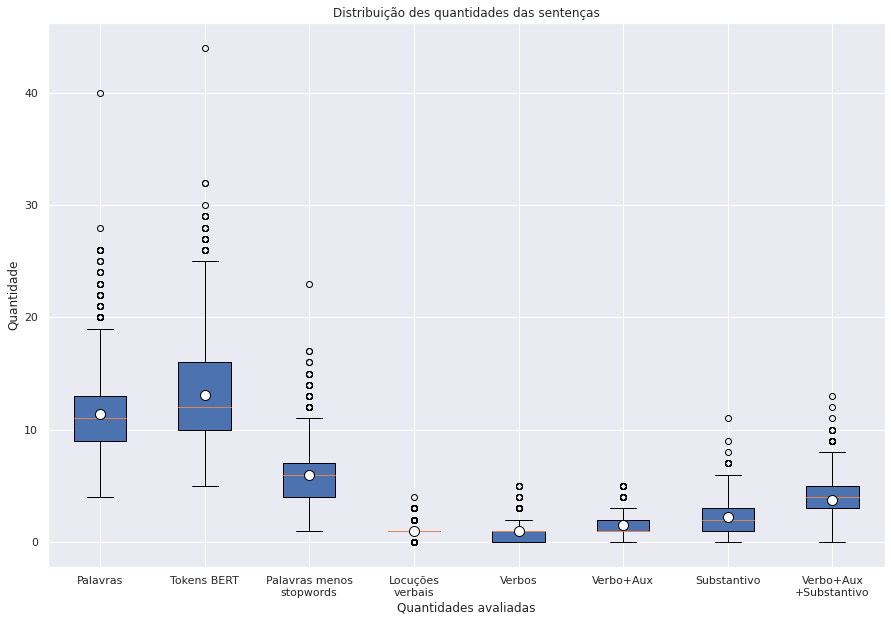

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição des quantidades das sentenças")
# Texto do eixo x
plt.xlabel("Quantidades avaliadas")
# Texto do eixo y
plt.ylabel("Quantidade")

colunas = [[x["qtdepalavras"] for x in stats_sentencas], 
           [x["qtdetokensbert"] for x in stats_sentencas],
           [x["qtdepalavrassemstopword"] for x in stats_sentencas],
           [x["qtdelocverbo"] for x in stats_sentencas],
           [x["qtdeverbo"] for x in stats_documentos],
           [x["qtdeverboaux"] for x in stats_documentos],
           [x["qtdesubstantivo"] for x in stats_documentos],
           [x["qtdeverbosauxsubstantivo"] for x in stats_documentos],
           ]

# Estrutura do gráfico
ax.boxplot(colunas, patch_artist=True, 
           showmeans=True,
           meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Rótulos para os boxplots
indices = [x for x in range(1, len(rotulos)+1)]
plt.xticks(indices, ["Palavras", 
                     "Tokens BERT", 
                     "Palavras menos\nstopwords", 
                     "Locuções\nverbais", 
                     "Verbos",
                     "Verbo+Aux", 
                     "Substantivo", 
                     "Verbo+Aux\n+Substantivo"])

# Mostra o gráfico
plt.show()

#### 5.3.4.2 POS Tagging

https://universaldependencies.org/docs/u/pos/

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 2)

# Cria um DataFrame das estatísticas
df_stats_sentencas_pos = pd.DataFrame([getSomaDic([x[2]]) for x in stats_sentencas_pos])

# Exibe as estatísticas
df_stats_sentencas_pos.describe()

,PRON,VERB,PUNCT,DET,NOUN,AUX,CCONJ,ADP,PROPN,ADJ,ADV,NUM,SCONJ,SYM,SPACE,INTJ,X
count,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1419.00,1.42e+03,1419.0,1.42e+03,3.00
mean,0.78,0.96,1.13,1.39,2.25,0.56,0.11,1.75,1.06,0.68,0.34,0.15,0.26,4.23e-03,0.0,7.05e-04,1.33
std,0.83,0.80,0.45,0.84,1.37,0.54,0.34,1.25,1.24,0.82,0.58,0.41,0.52,6.49e-02,0.0,2.65e-02,0.58
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
25%,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
50%,1.00,1.00,1.00,1.00,2.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.00
75%,1.00,1.00,1.00,2.00,3.00,1.00,0.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00e+00,0.0,0.00e+00,1.50
max,4.00,5.00,5.00,6.00,11.00,3.00,3.00,8.00,10.00,5.00,4.00,3.00,3.00,1.00e+00,0.0,1.00e+00,2.00


In [ ]:
# Converte os dados para o boxplot
lista_postagging = []
# Percorre as estatísticas pos dos documentos
for x in stats_sentencas_pos:
    # Soma as estatísticas das sentencas do documento
    posx = getSomaDic([x[2]])      
    for chave, valor in posx.items():
        lista_postagging.append([x[0], chave, valor])

# Converte em um dataframe
df_stats_sentencas_pos = pd.DataFrame(lista_postagging, columns=("id", "pos", "qtde")) 

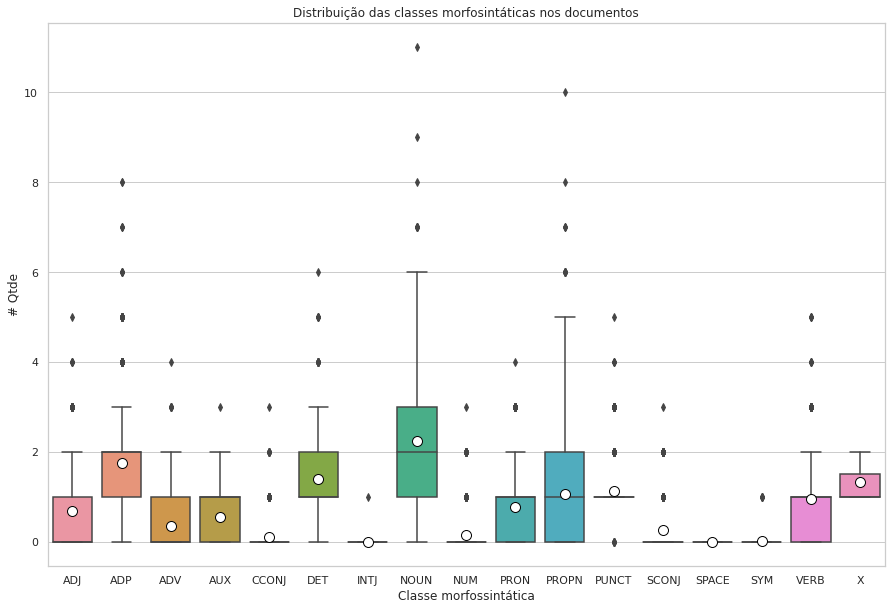

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Lista em ordem alfabética das colunas
ordem = sorted(df_stats_sentencas_pos['pos'].unique())

# Insere os dados no gráfico com o ponto(branco) da média do grupo
box_plot = sns.boxplot(x = "pos", y = "qtde", data = df_stats_sentencas_pos, order = ordem, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Título do Gráfico
plt.title("Distribuição das classes morfosintáticas nos documentos")
# Texto do eixo x
plt.xlabel("Classe morfossintática")
# Texto do eixo y
plt.ylabel("# Qtde")

# Mostra o gráfico
plt.show()

Quantidade de ocorrências de classes morfossintática por sentença

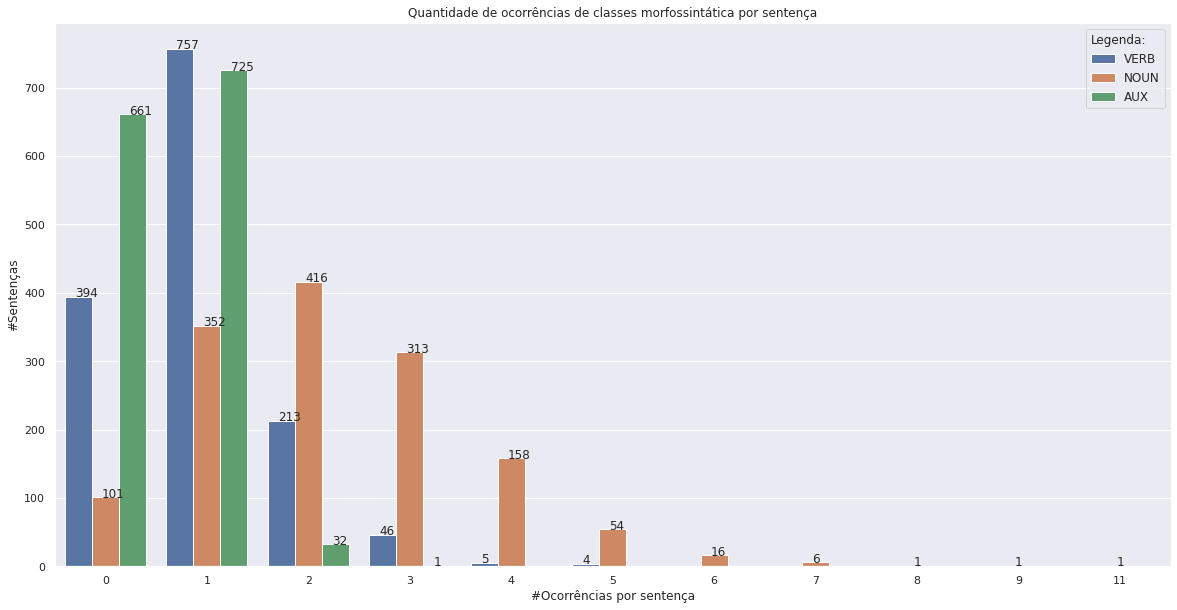

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

df_pos = df_stats_sentencas_pos[df_stats_sentencas_pos["pos"].isin(["NOUN","VERB","AUX"])]

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x="qtde",hue="pos"  ,data=df_pos)

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate('{0:g}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.1))
    
plt.title("Quantidade de ocorrências de classes morfossintática por sentença")
plt.xlabel("#Ocorrências por sentença")
plt.ylabel("#Sentenças")

# Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
plt.legend(title='Legenda:', loc='upper right', fontsize=12)._legend_box.align='left'

plt.show()

Ex.: Existe 20(#Sentenças) sentenças onde palavras da classe morfossintática verbo(azul legenda) ocorrem uma vez(#Ocorrências por sentença).

#### 5.3.4.3 Gráficos POS Tagging de sentenças do documento original

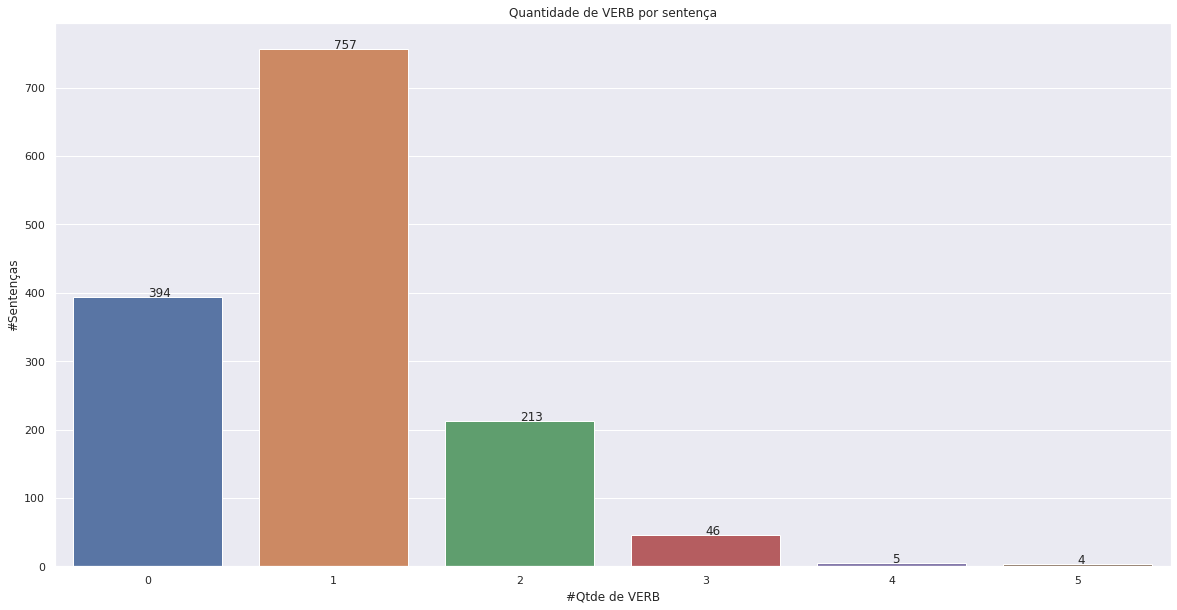

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="VERB"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de VERB por sentença")
plt.xlabel("#Qtde de VERB")
plt.ylabel("#Sentenças")

plt.show()

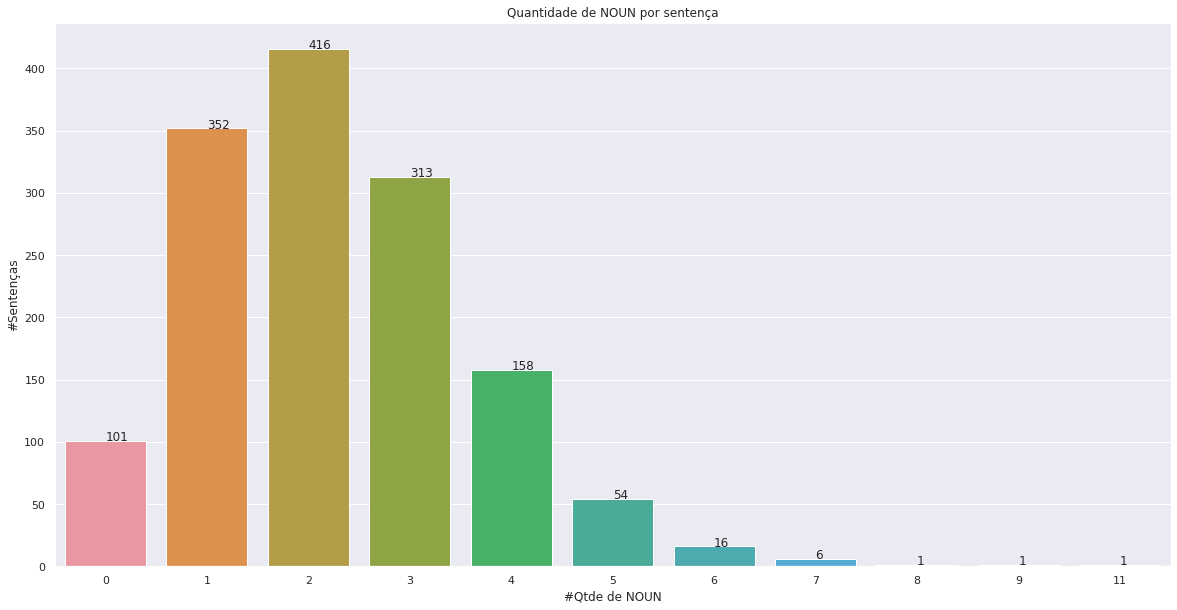

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="NOUN"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de NOUN por sentença")
plt.xlabel("#Qtde de NOUN")
plt.ylabel("#Sentenças")

plt.show()

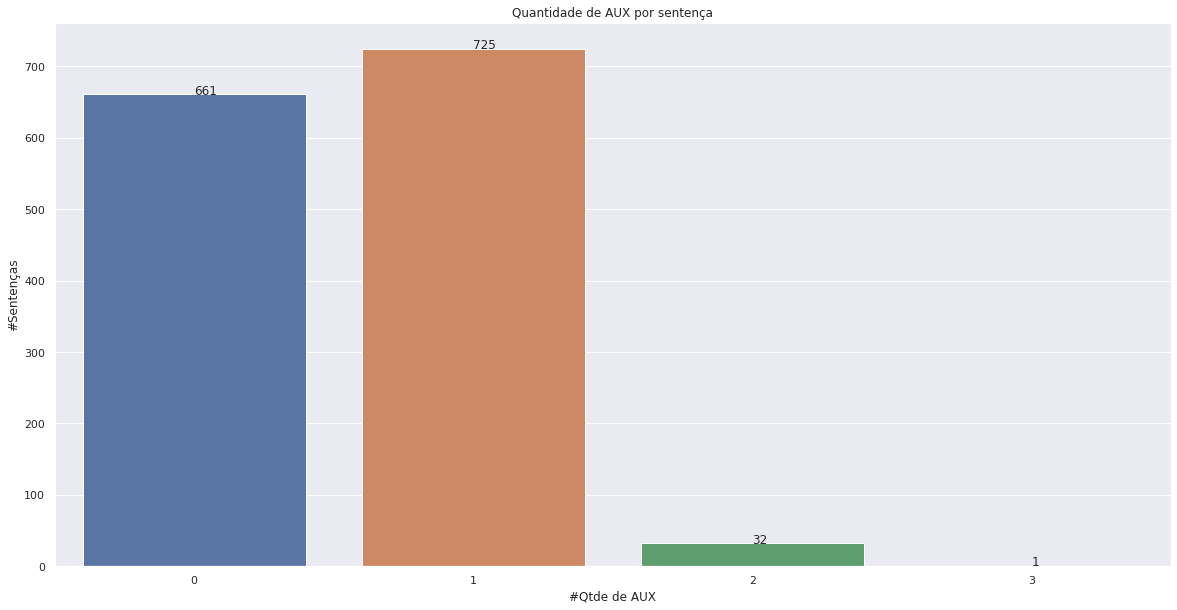

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="AUX"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de AUX por sentença")
plt.xlabel("#Qtde de AUX")
plt.ylabel("#Sentenças")

plt.show()

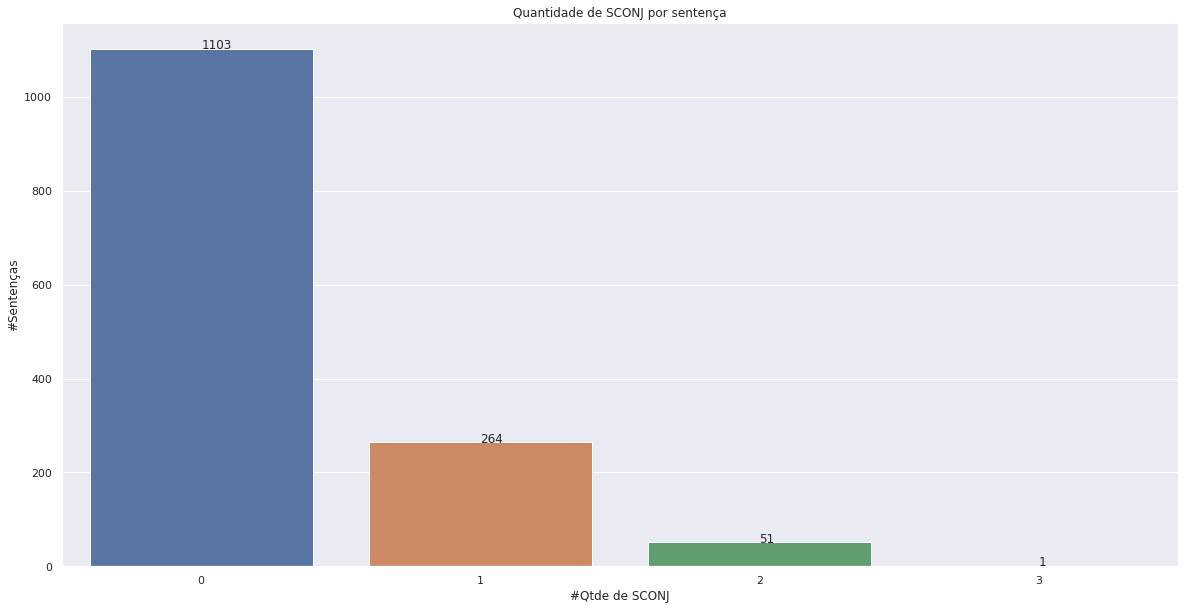

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="SCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de SCONJ por sentença")
plt.xlabel("#Qtde de SCONJ")
plt.ylabel("#Sentenças")

plt.show()

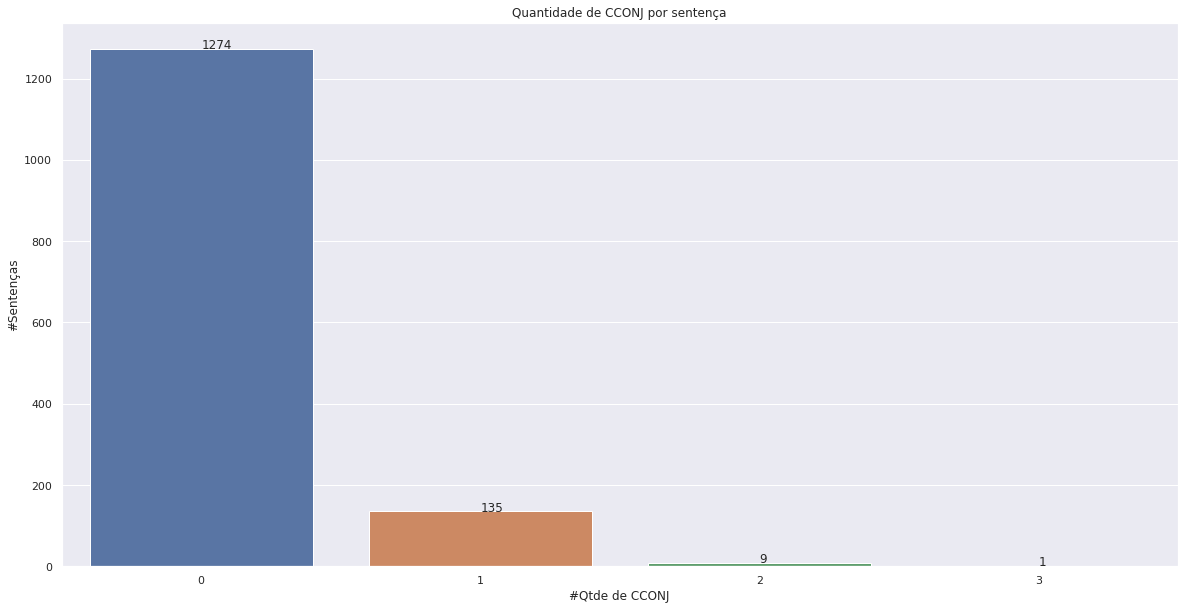

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="CCONJ"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de CCONJ por sentença")
plt.xlabel("#Qtde de CCONJ")
plt.ylabel("#Sentenças")

plt.show()

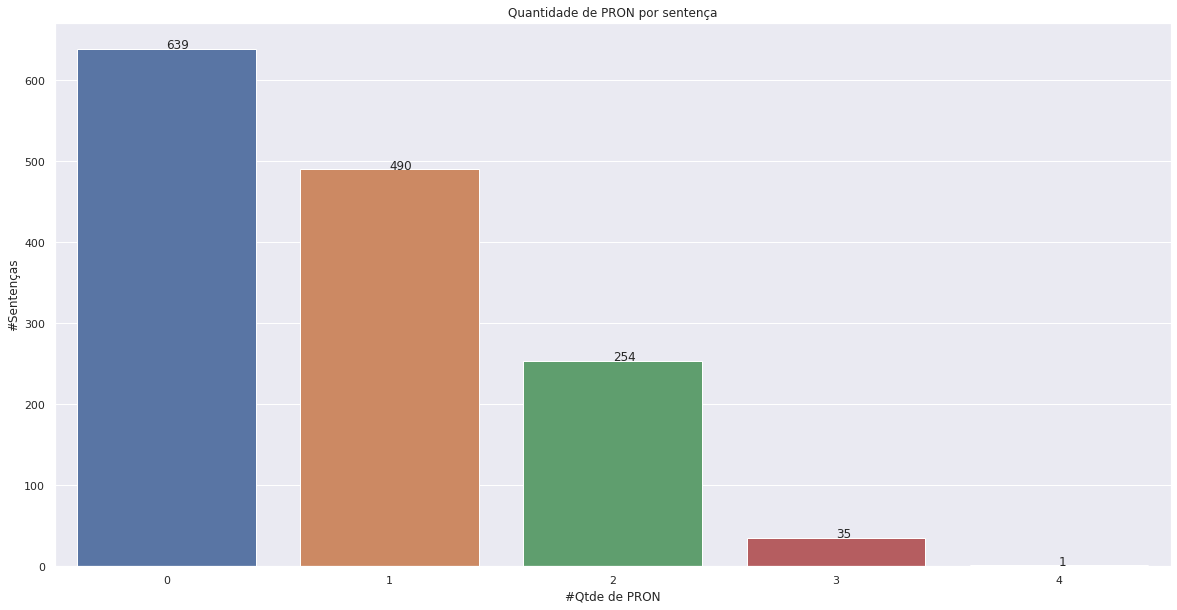

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtde"] for i, f in df_stats_sentencas_pos.iterrows() if f["pos"]=="PRON"])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de PRON por sentença")
plt.xlabel("#Qtde de PRON")
plt.ylabel("#Sentenças")

plt.show()

### 5.3.5 Por Documento

#### 5.3.5.1 Gráfico Quantidade de documentos perturbados por quantidade de sentenças

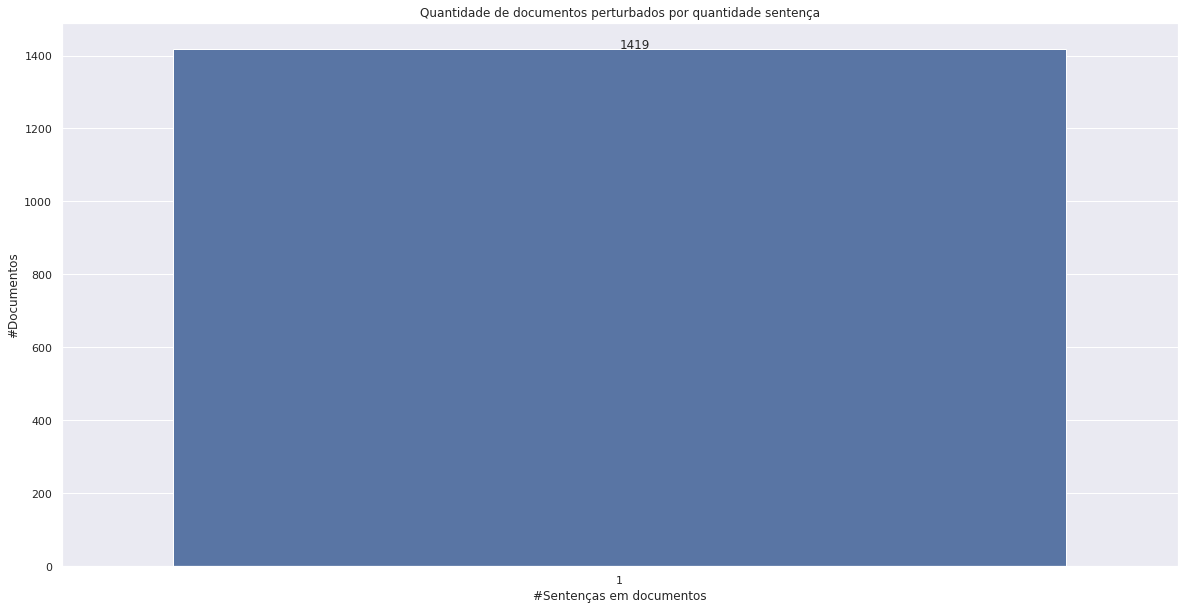

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesentencas"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade sentença")
plt.xlabel("#Sentenças em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.2 Gráfico Quantidade de documentos perturbados por quantidade de palavras

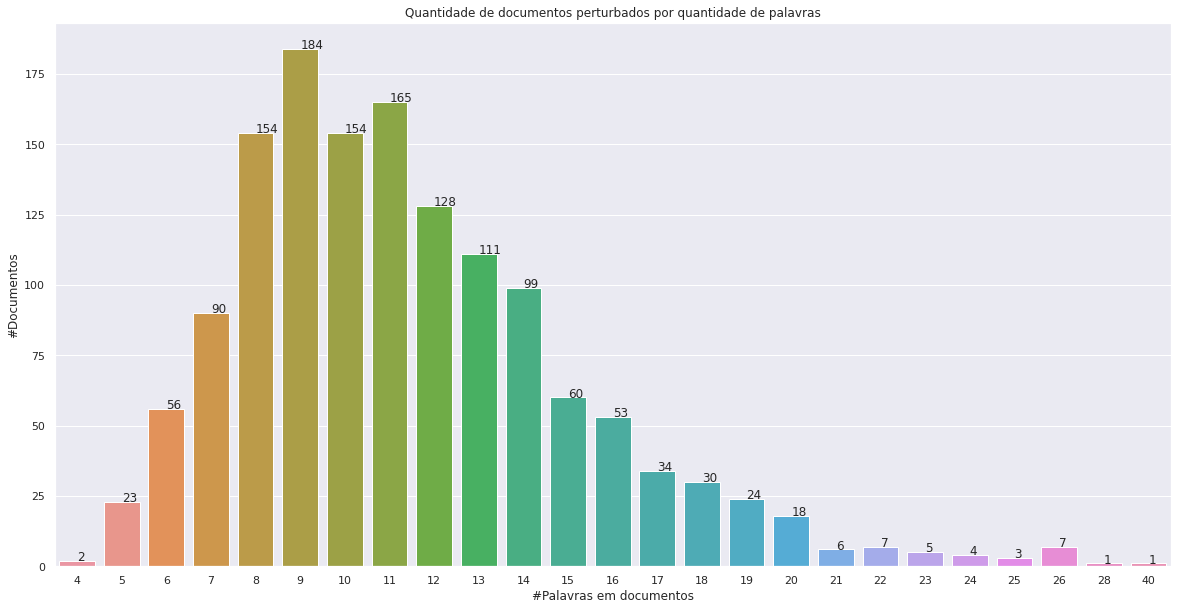

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de palavras")
plt.xlabel("#Palavras em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.3 Gráfico Quantidade de documentos perturbados por quantidade de tokens

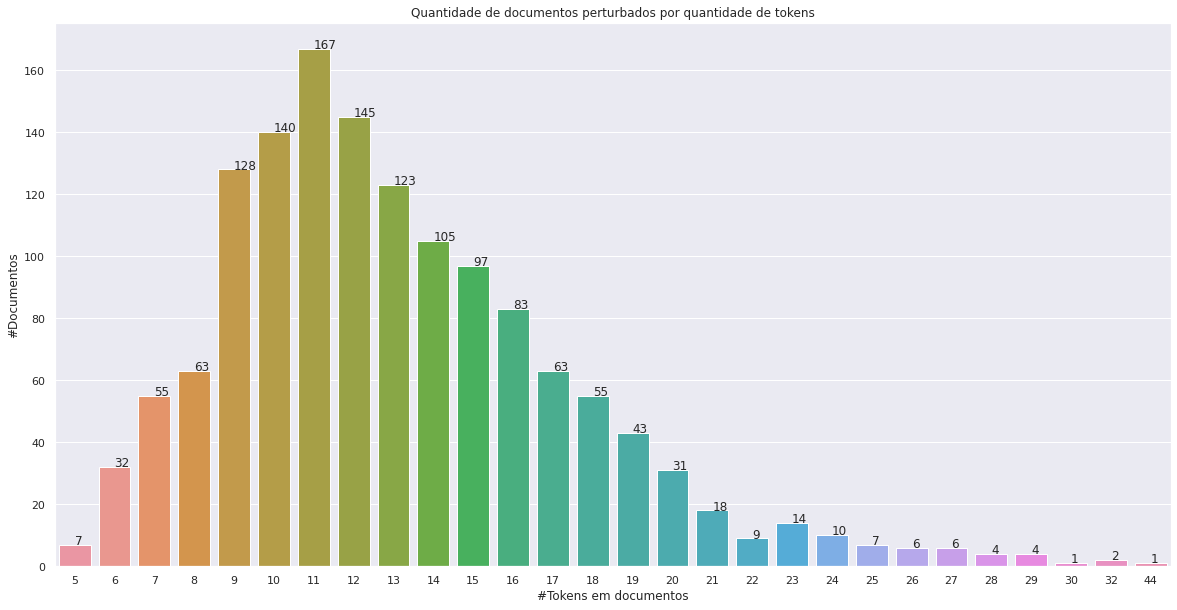

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de tokens")
plt.xlabel("#Tokens em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.4 Gráfico Quantidade de documentos perturbados por quantidade de palavras desconsiderando as stopword

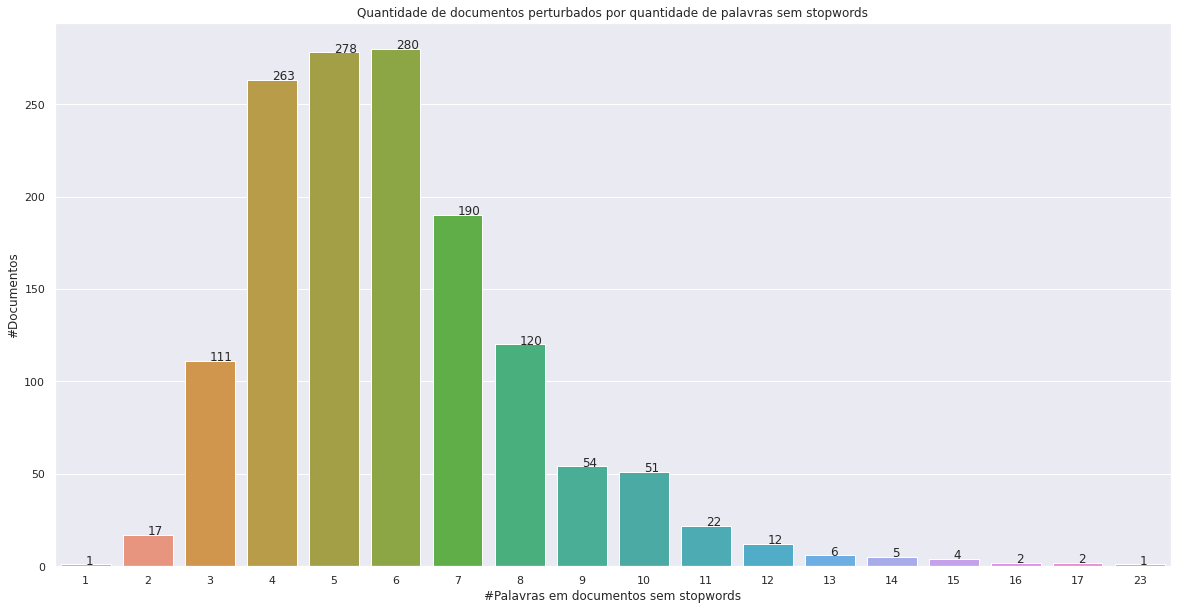

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de palavras sem stopwords")
plt.xlabel("#Palavras em documentos sem stopwords")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.5 Gráfico Quantidade de documentos perturbados por quantidade de locuções verbais

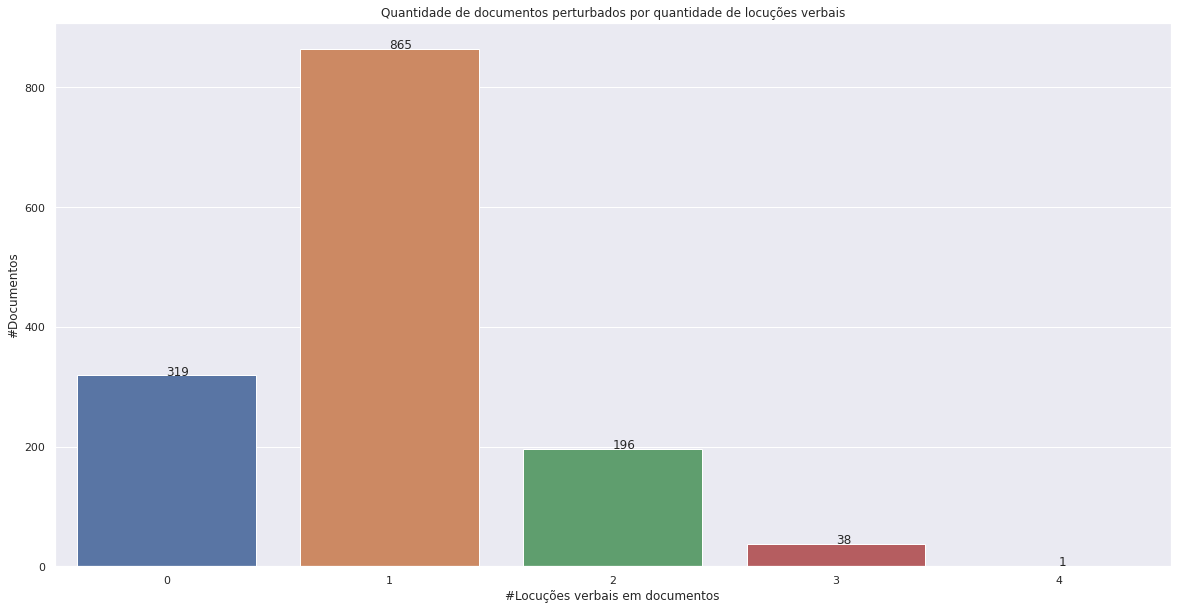

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.6 Gráfico Quantidade de documentos perturbados por quantidade de verbos

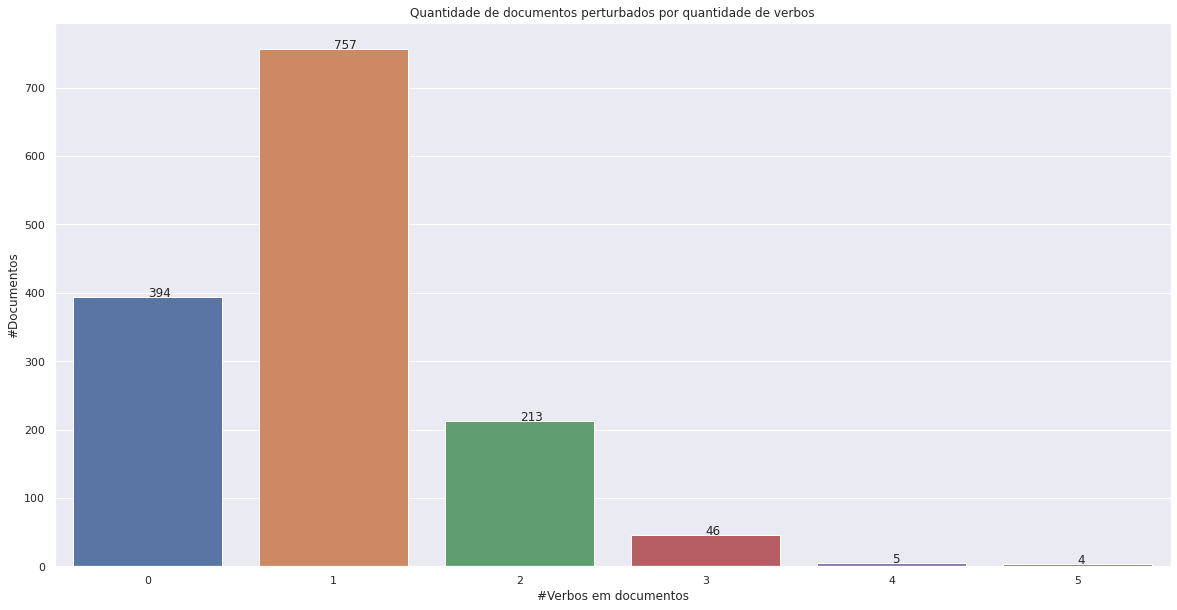

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de verbos")
plt.xlabel("#Verbos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.7 Gráfico Quantidade de documentos perturbados por quantidade de verbos e aux

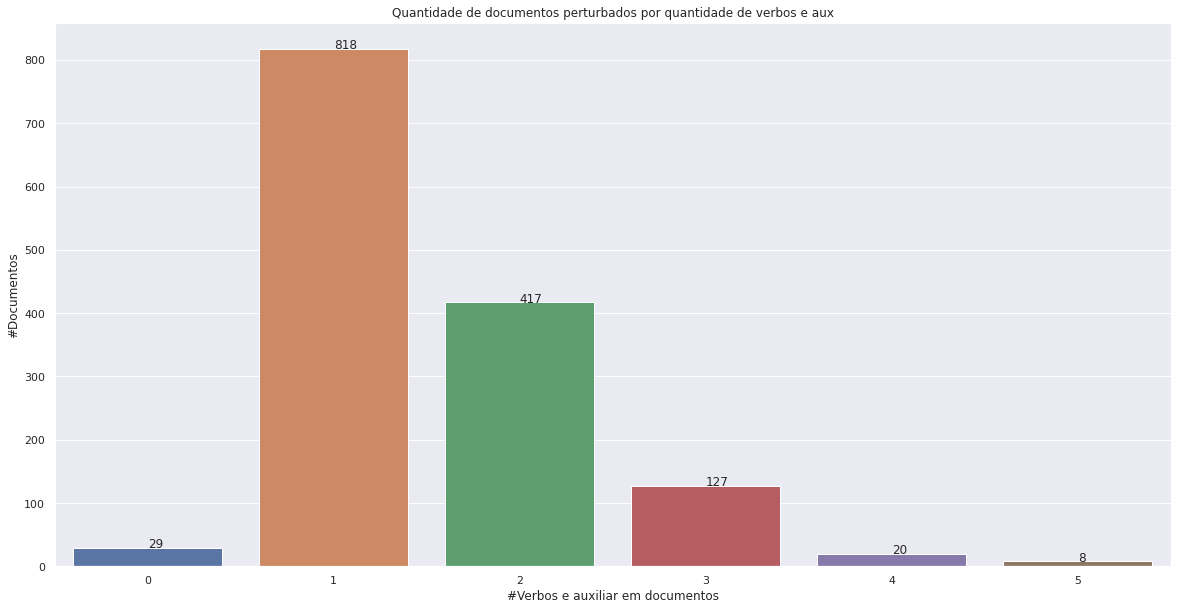

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.8 Gráfico Quantidade de documentos perturbados por quantidade de substantivos

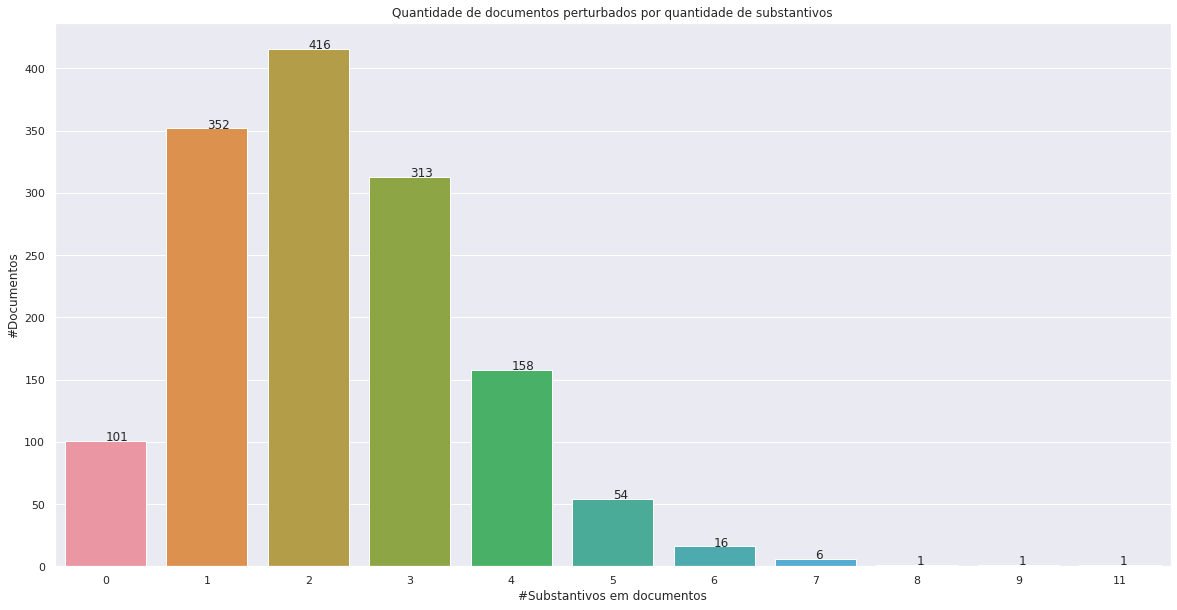

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de substantivos")
plt.xlabel("#Substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.9 Gráfico Quantidade de documentos perturbados por quantidade de verbos(AUX) e substantivo

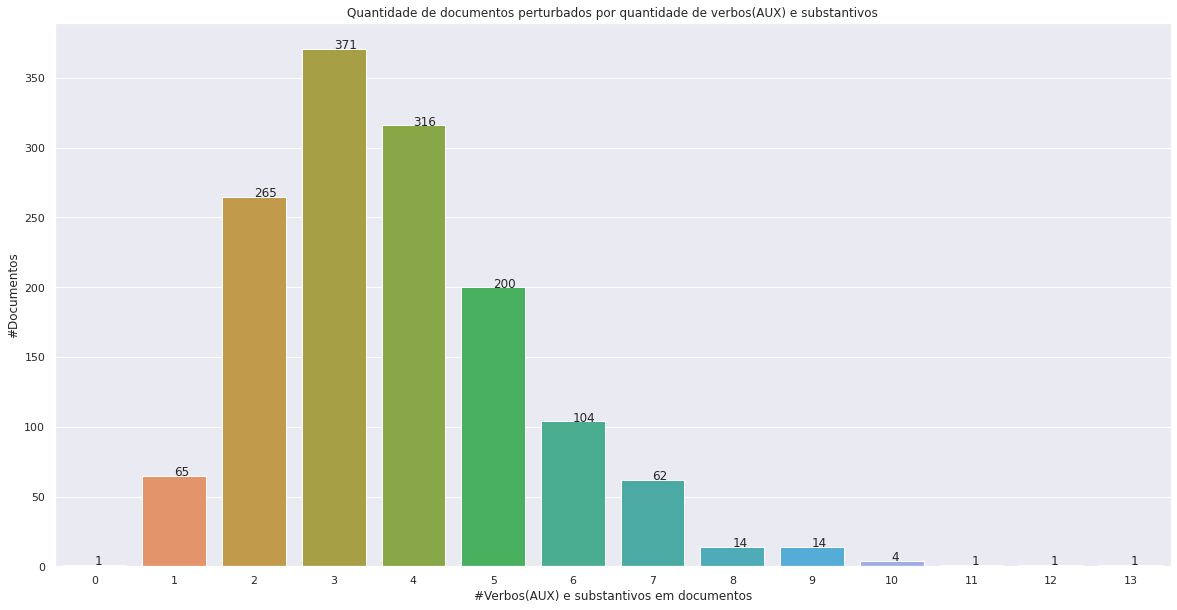

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbosauxsubstantivo"] for f in stats_documentos])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de documentos perturbados por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em documentos")
plt.ylabel("#Documentos")

plt.show()

#### 5.3.5.10 Gráfico da distribuição do comprimento dos documentos tokenizados

In [ ]:
# Recupera o comprimento dos documentos tokenizados
tamanhos_sentencas = [len(x) for x in documento_tokenizado]

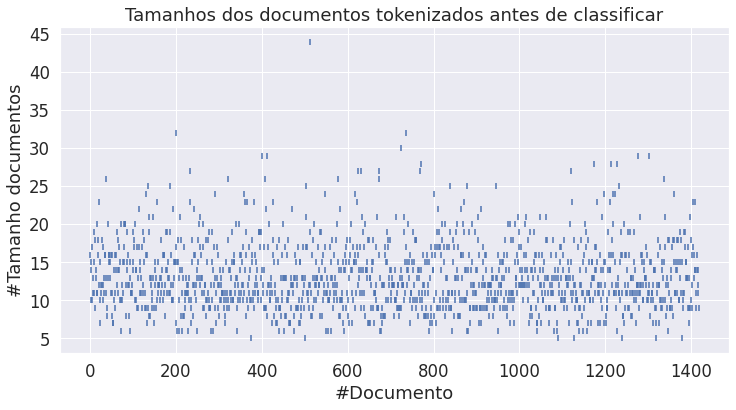

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Adiciona os valores as colunas
plt.scatter(range(0, len(tamanhos_sentencas)), tamanhos_sentencas, marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados antes de classificar")

plt.show()

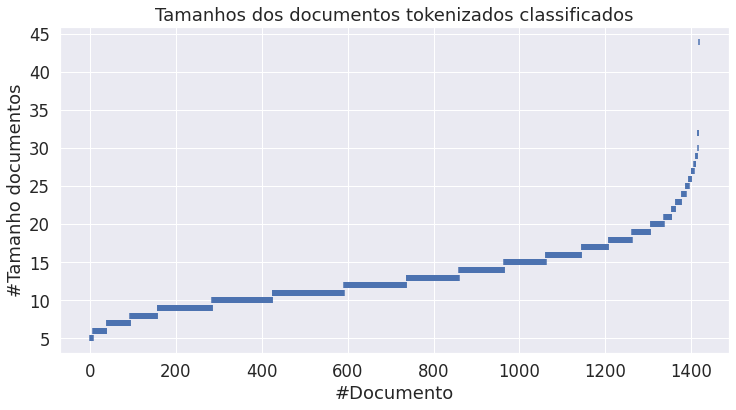

In [ ]:
# Import das bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(tamanhos_sentencas)), sorted(tamanhos_sentencas), marker="|")

plt.xlabel("#Documento")
plt.ylabel("#Tamanho documentos")
plt.title("Tamanhos dos documentos tokenizados classificados")

plt.show()

### 5.3.6 Por sentença

#### 5.3.6.1 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de palavras

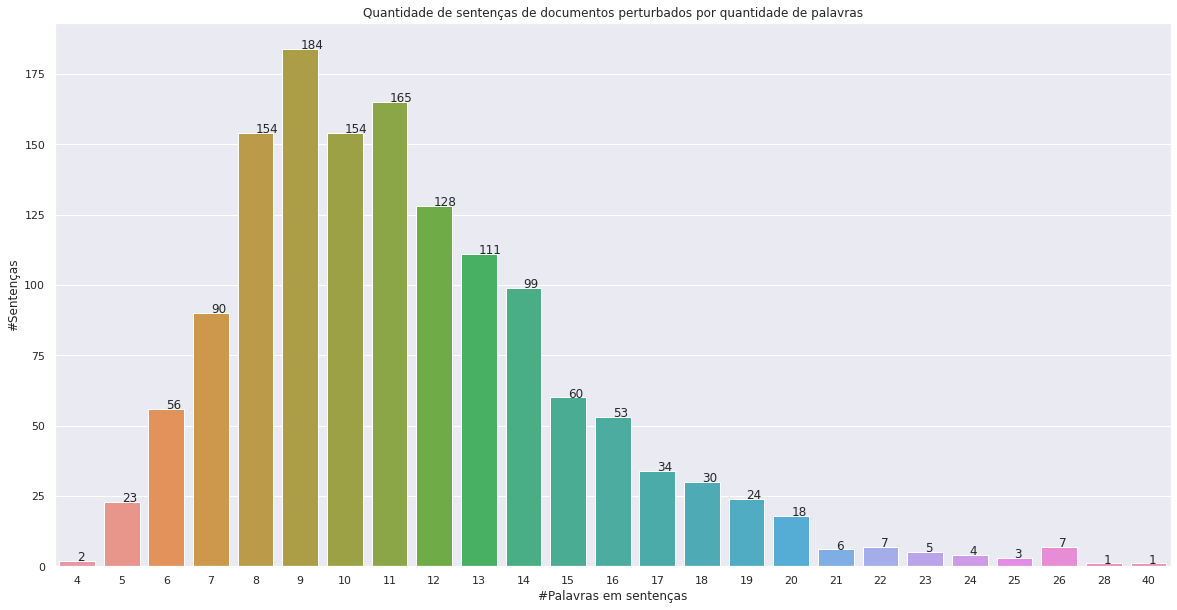

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavras"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de palavras")
plt.xlabel("#Palavras em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.2 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de tokens

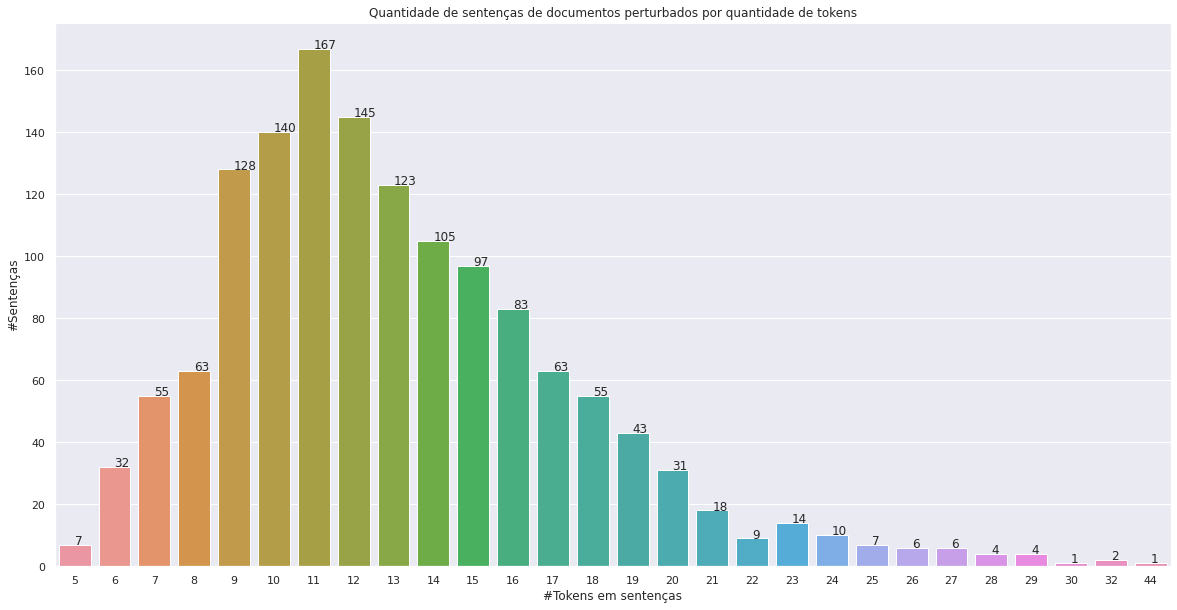

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdetokensbert"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de tokens")
plt.xlabel("#Tokens em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.3 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de palavras desconsiderando stopwords

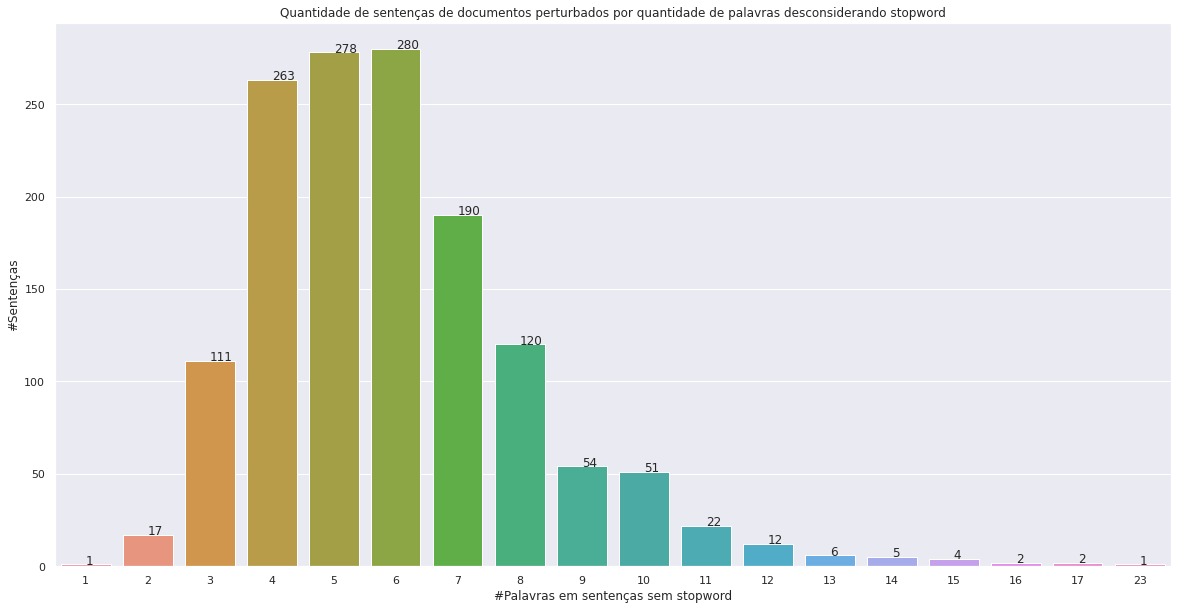

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdepalavrassemstopword"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de palavras desconsiderando stopword")
plt.xlabel("#Palavras em sentenças sem stopword")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.4 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de locuções verbais

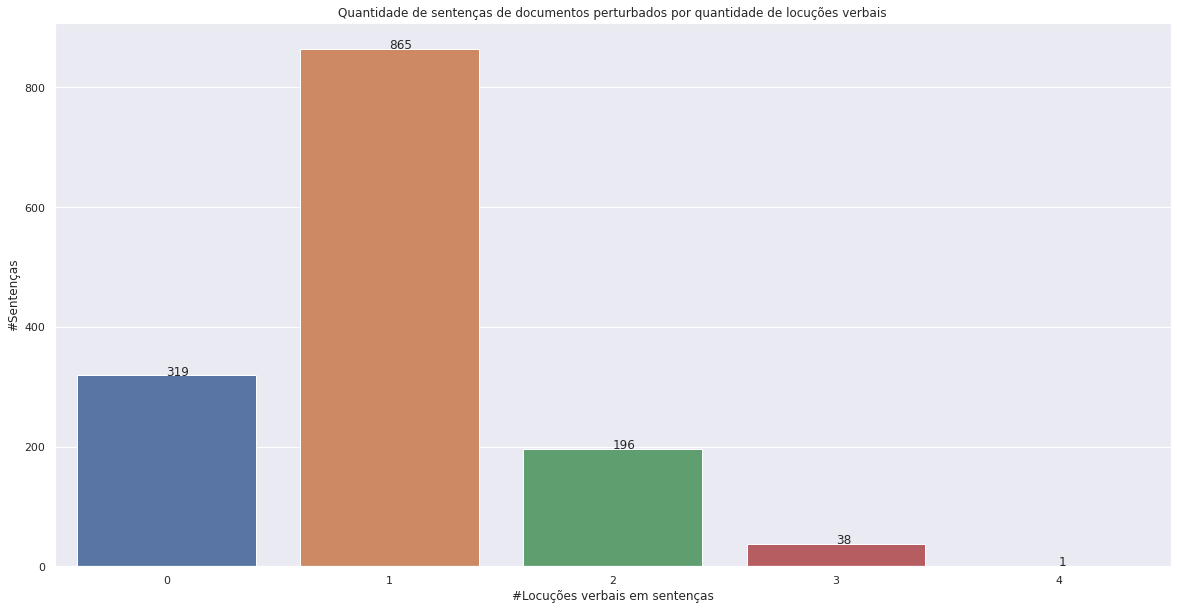

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdelocverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de locuções verbais")
plt.xlabel("#Locuções verbais em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.5 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de verbos

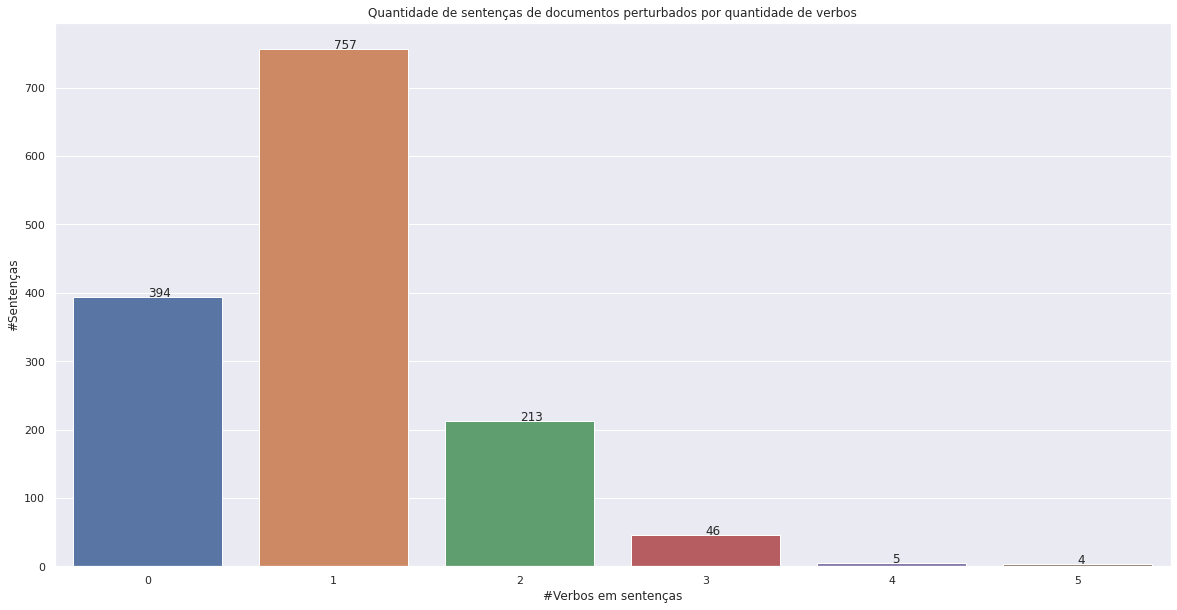

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverbo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de verbos")
plt.xlabel("#Verbos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.6 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de verbos e aux

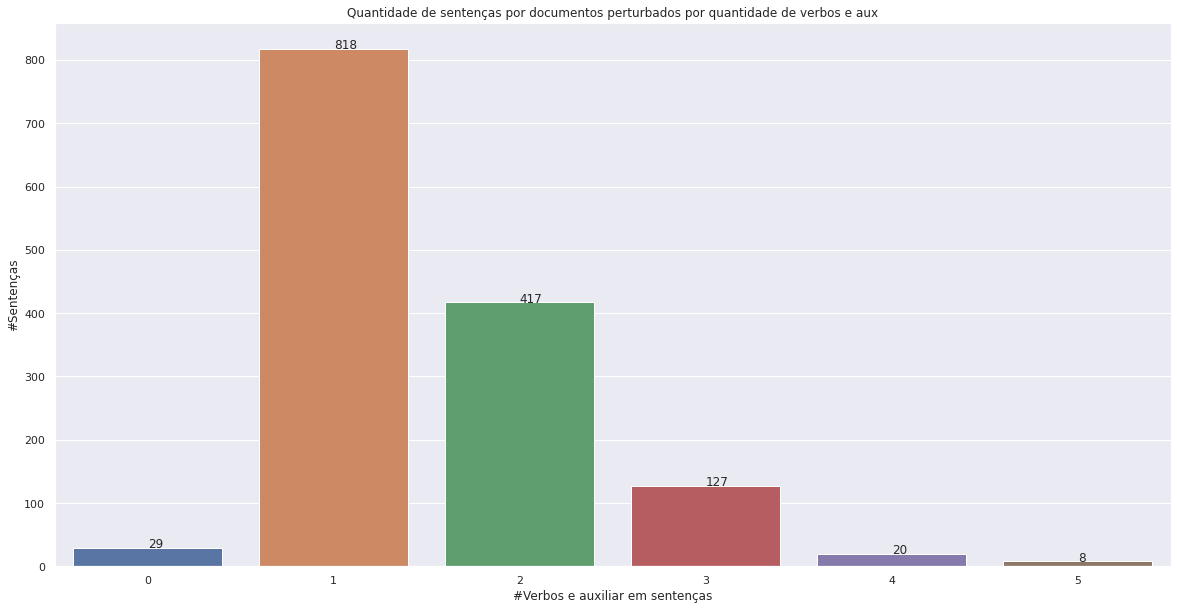

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboaux"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças por documentos perturbados por quantidade de verbos e aux")
plt.xlabel("#Verbos e auxiliar em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.7 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de substantivos

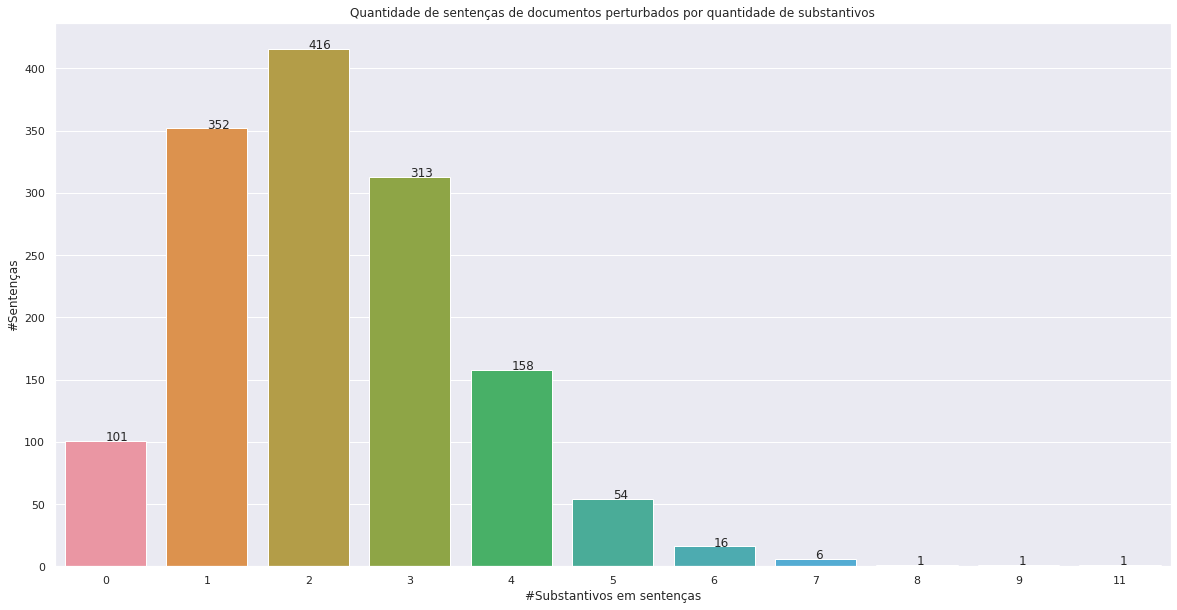

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdesubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:    
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de substantivos")
plt.xlabel("#Substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

#### 5.3.6.8 Gráfico Quantidade de sentenças de documentos perturbados por quantidade de verbos(AUX) e substantivo

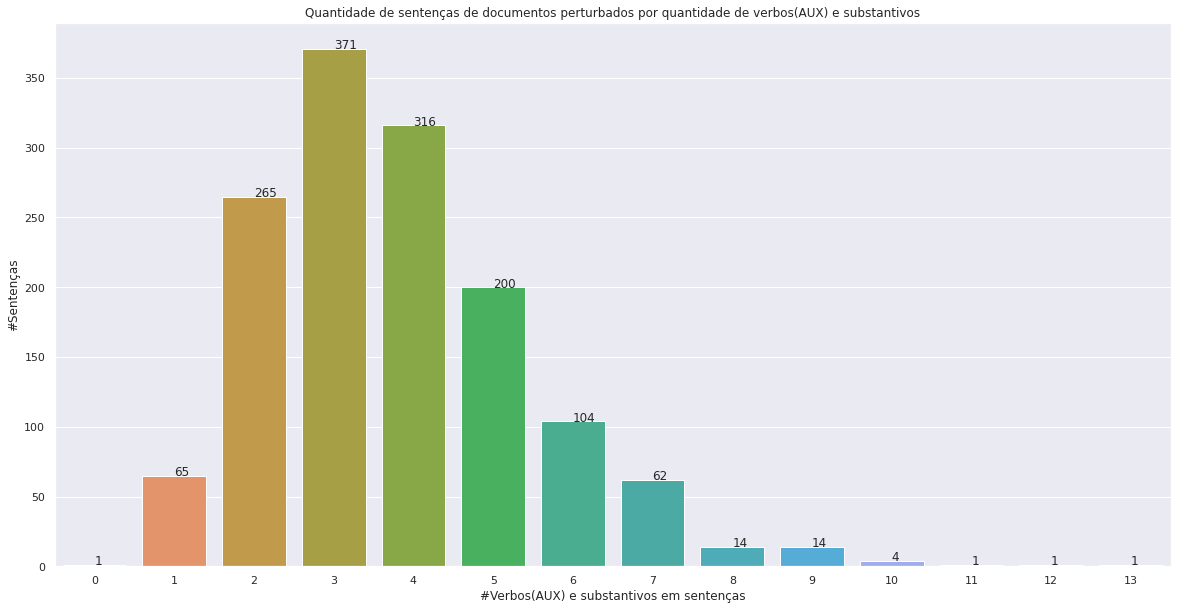

In [ ]:
# Import das bibliotecas.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams["figure.figsize"] = (20,10)

# Plota o número de tokens de cada tamanho
ax = sns.countplot(x=[f["qtdeverboauxsubstantivo"] for f in stats_sentencas])

# Adiciona os valores as colunas
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.4, p.get_height()+0.1))

plt.title("Quantidade de sentenças de documentos perturbados por quantidade de verbos(AUX) e substantivos")
plt.xlabel("#Verbos(AUX) e substantivos em sentenças")
plt.ylabel("#Sentenças")

plt.show()

# 6 Finalização

## 6.1 Tempo final de processamento





In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:04:59 (h:mm:ss)
